In [1]:

import cooler
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import multiprocessing as mp
import h5py
import pickle
import seaborn as sns
import tqdm

from scipy import stats

from statsmodels.stats.multitest import multipletests

import sys
import itertools
import time

sys.path.insert(0, '/cndd/fangming/CEMBA/snmcseq_dev')
from __init__ import *
from __init__jupyterlab import * 
import snmcseq_utils

from enhancer_gene_hic_validation_utils import *
from hic_plot_utils import *

In [2]:
ttest_routine

<function hic_plot_utils.ttest_routine>

In [3]:
default_colorbar_kws = DEFAULT_COLORBAR_KWS

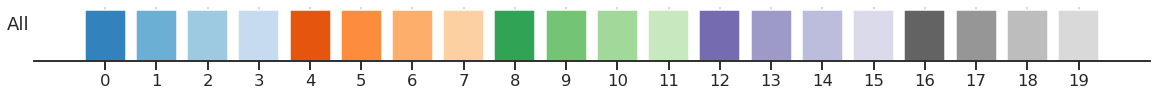

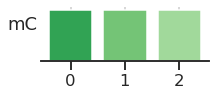

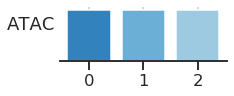

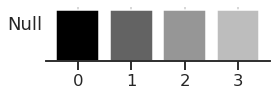

In [4]:
# color palette
cm = plt.cm.tab20c.colors

# settle down on a color palette
colors_mc = [cm[8], cm[9], cm[10],]
colors_atac = [cm[0], cm[1], cm[2],]
colors_null = ['black', cm[16], cm[17], cm[18],]

color_tracks = [
    cm,
    colors_mc,
    colors_atac,
    colors_null,
]

labels = [
    'All',
    'mC',
    'ATAC',
    'Null',
]

for color_track, label in zip(color_tracks, labels):
    n = len(color_track)
    fig, ax = plt.subplots(figsize=(1*n,1))
    ax.bar(np.arange(n), 1, 
           color=color_track)
    ax.set_xticks(np.arange(n))
    ax.set_ylabel(label, rotation=0, ha='right')
    sns.despine(ax=ax, left=True)
    ax.set_yticks([])
    plt.show()

In [5]:
mod_palette = {
    'mc': 'C2',
    'atac': 'C0',
    'null': 'k',
}

mod_palette_comp = {
    'mc': colors_mc,
    'atac': colors_atac,
    'null': colors_null,
}


KB = 1000
def p25(x):
    return np.percentile(x, 25)
def p75(x):
    return np.percentile(x, 75)


In [6]:
track_names = [
    'linked_mc',
    'linked_atac',
    'linked_both',
    'correlated_mc',
    'correlated_atac',
    'correlated_both',
]

track_palette = {
    'linked_mc': mod_palette_comp['mc'][0],
    'linked_atac': mod_palette_comp['atac'][0],
    'linked_both': 'C1',
    'correlated_mc': mod_palette_comp['mc'][2],
    'correlated_atac': mod_palette_comp['atac'][2],
    'correlated_both': 'C3',
}

celltype_palette = {
    'L2_3': '#845EC2',
    'L4': '#D65DB1',
    'L5': '#FF6F91',
    'L6': '#FF9671',
    'Pvalb': '#FFC75F',
    'Sst': '#F9F871',
    'Vip': '#2C73D2',
    'Ndnf': '#008E9B',
}

chromosomes = ['chr'+str(i+1) for i in range(22)] + ['chrX']
celltypes = ['L2_3', 'L4', 'L5', 'L6', 
             'Pvalb', 'Sst', 'Vip', 'Ndnf']
resolution = 10000

In [7]:
celltype = '{}'
resolution = 10000
active_th = 50
date = '2020-12-22'

min_match = 0.8

input_res_metaformat = ('/cndd2/fangming/sphere_old/enhancers/scripts/results_new/'
              'hic_contact_enrichment_metacell_liftover{:.2f}_celltypespec_{{}}_{{}}_{{}}_{{}}.pkl' #.format(min_match, int(100*active_th), celltype, resolution, today)
) 

output_fig_metaformat = ('/cndd2/fangming/sphere_old/enhancers/scripts/figures/'
              'hic_contact_enrichment_metacell_liftover{:.2f}_celltypespec_{{}}.pdf' #.format(min_match, ...)
) 

# print(input_res_metaformat)
# print(input_res_metaformat.format(0.7))
input_res_format = input_res_metaformat.format(min_match) #.format(int(100*active_th), celltype, resolution, today)
print(input_res_format)
output_fig_format = output_fig_metaformat.format(min_match)
print(output_fig_format)

/cndd2/fangming/sphere_old/enhancers/scripts/results_new/hic_contact_enrichment_metacell_liftover0.80_celltypespec_{}_{}_{}_{}.pkl
/cndd2/fangming/sphere_old/enhancers/scripts/figures/hic_contact_enrichment_metacell_liftover0.80_celltypespec_{}.pdf


# one cell type

In [8]:
celltype = 'L2_3'
input_res = input_res_format.format(active_th, celltype, resolution, date)

# get 
with open(input_res, 'rb') as fh:
    (distances, 
     contacts_mean, contacts_std, contacts_n,
     contacts_sig_pairs_mean, 
     contacts_sig_pairs_std, 
     contacts_sig_pairs_n, 
    ) = pickle.load(fh)
    
p_th1 = 0.05
p_th2 = 0.001

(mean_fcs_bck, padjs_bck, 
 mean_fcs_correlated, padjs_correlated,) = ttest_routine(contacts_mean, contacts_std, contacts_n, 
                                                          contacts_sig_pairs_mean,
                                                          contacts_sig_pairs_std,
                                                          contacts_sig_pairs_n,
                                                          p_th1=p_th1, p_th2=p_th2)

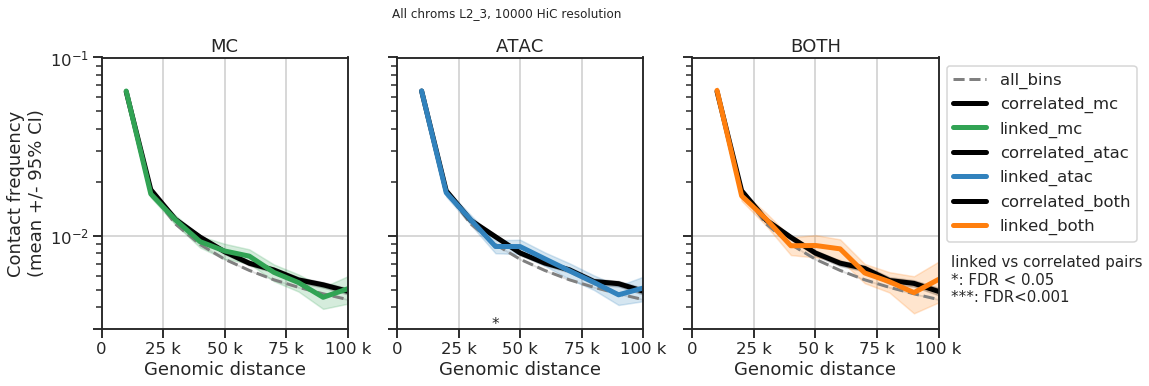

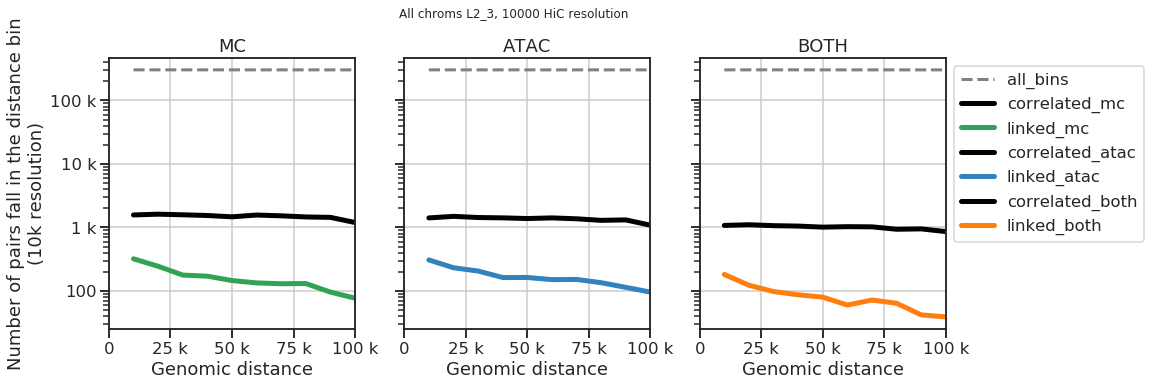

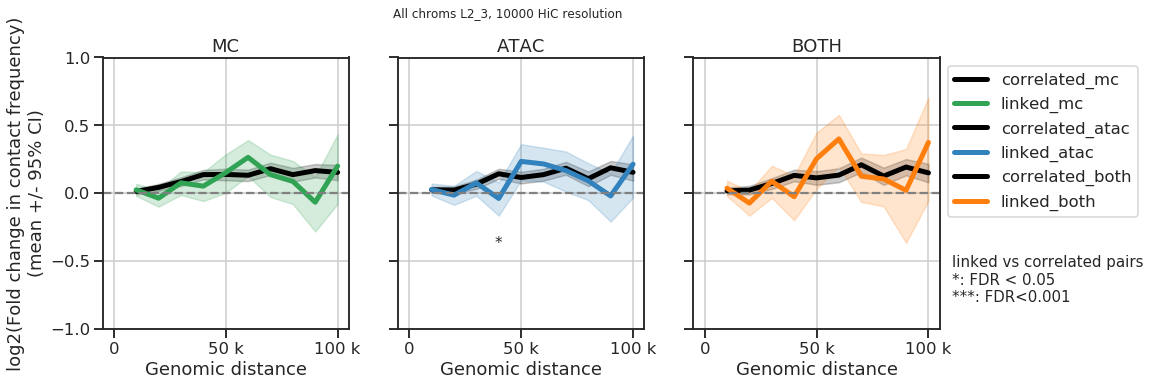

In [9]:
output_fig = output_fig_format.format("{}_{}_plot1_v3".format(celltype, resolution))
plot1_v3(distances, celltype, resolution, 
         track_names, track_palette, 
         contacts_mean, contacts_std, contacts_n, 
         contacts_sig_pairs_mean, contacts_sig_pairs_std, contacts_sig_pairs_n,
         padjs_correlated,
         output_fig,
         )

output_fig = output_fig_format.format("{}_{}_plot1_v3_cov_test".format(celltype, resolution))
plot1_v3_cov(distances, celltype, resolution, 
         track_names, track_palette,
         contacts_mean, contacts_std, contacts_n, 
         contacts_sig_pairs_mean, contacts_sig_pairs_std, contacts_sig_pairs_n,
         output_fig,
         )

output_fig = output_fig_format.format("{}_{}_plot1_v4_test".format(celltype, resolution))
plot1_v4(distances, celltype, resolution, 
         track_names, track_palette, 
         contacts_mean, contacts_std, contacts_n, 
         contacts_sig_pairs_mean, contacts_sig_pairs_std, contacts_sig_pairs_n,
         padjs_correlated,
         output_fig,
          ylim=[-1, 1],
          yticks=[-1, -0.5, 0, 0.5, 1],
         )

# all cell types

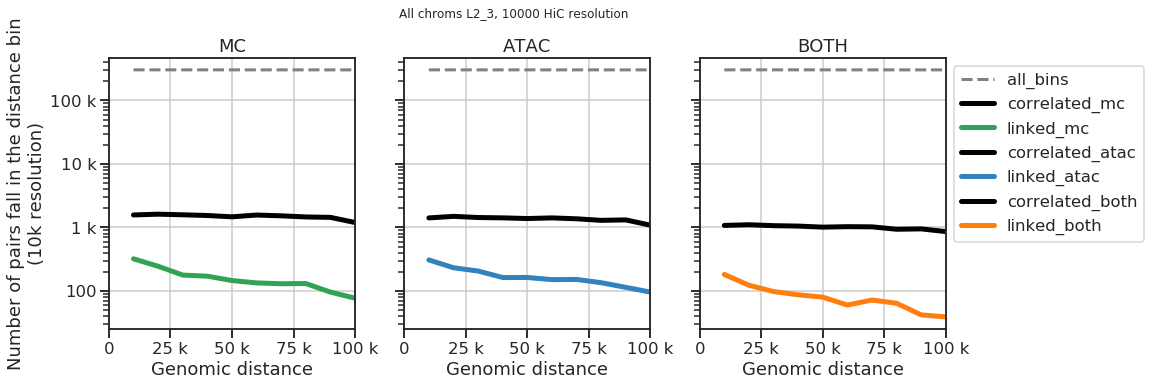

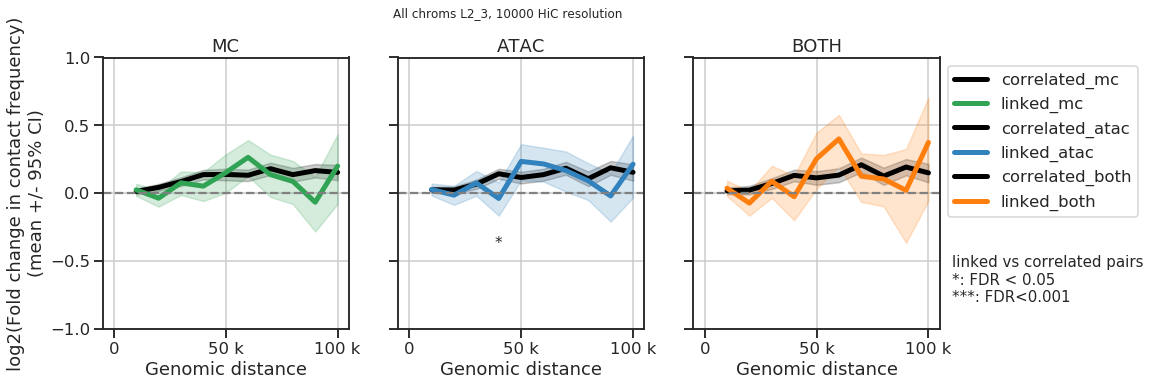

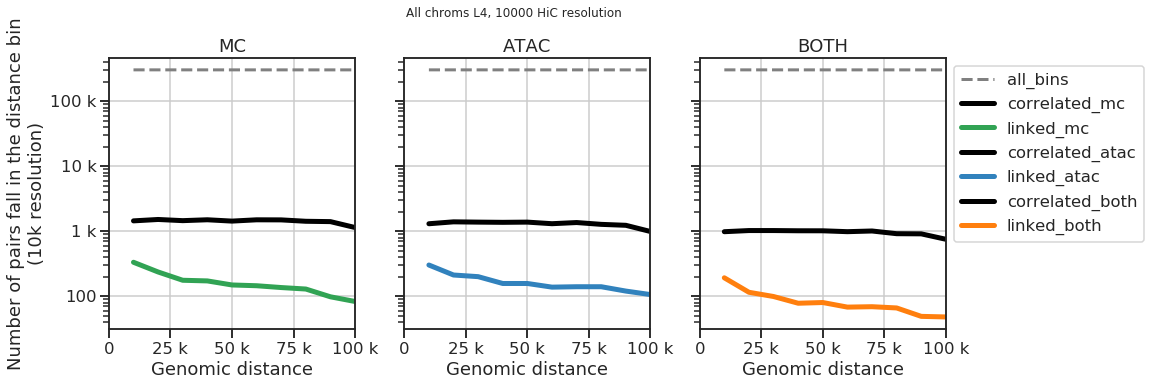

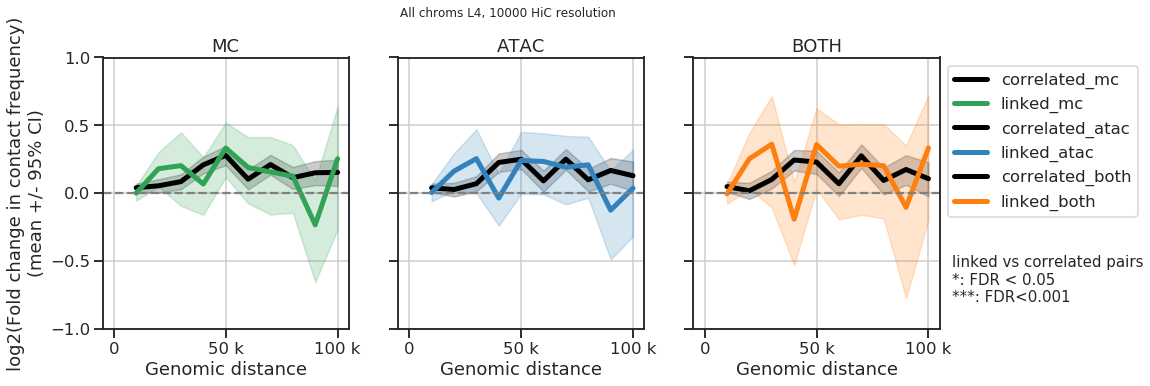

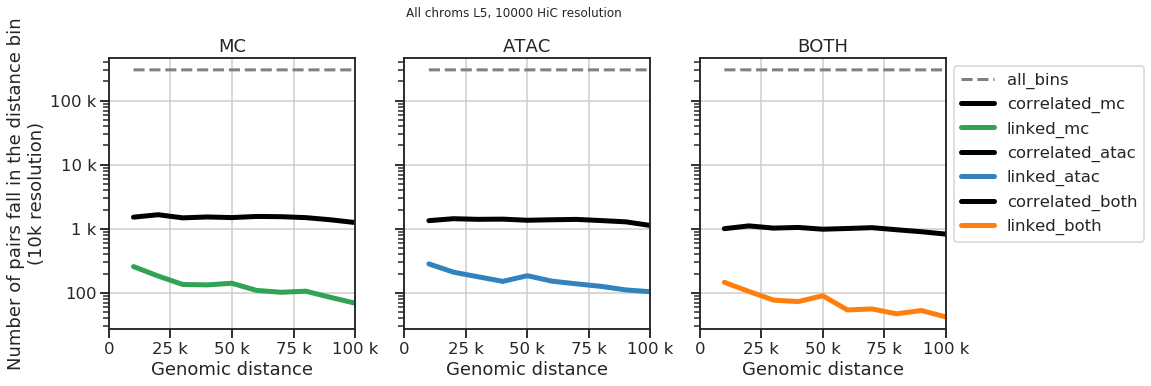

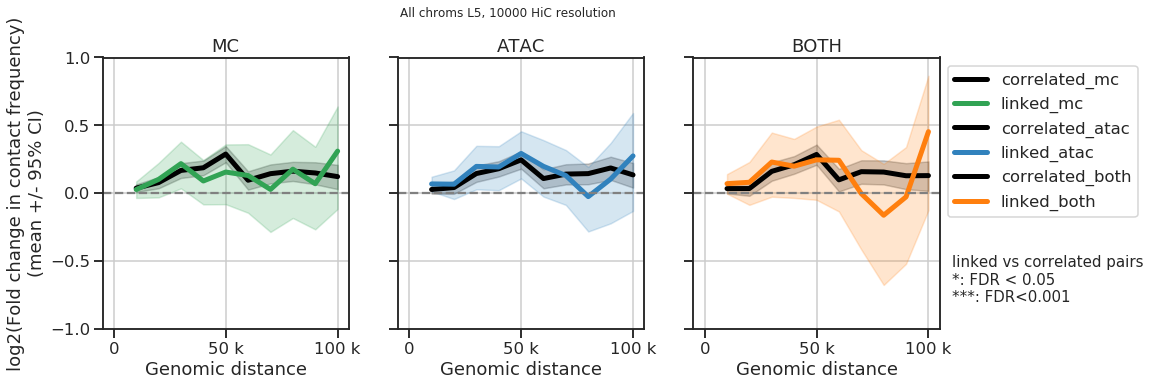

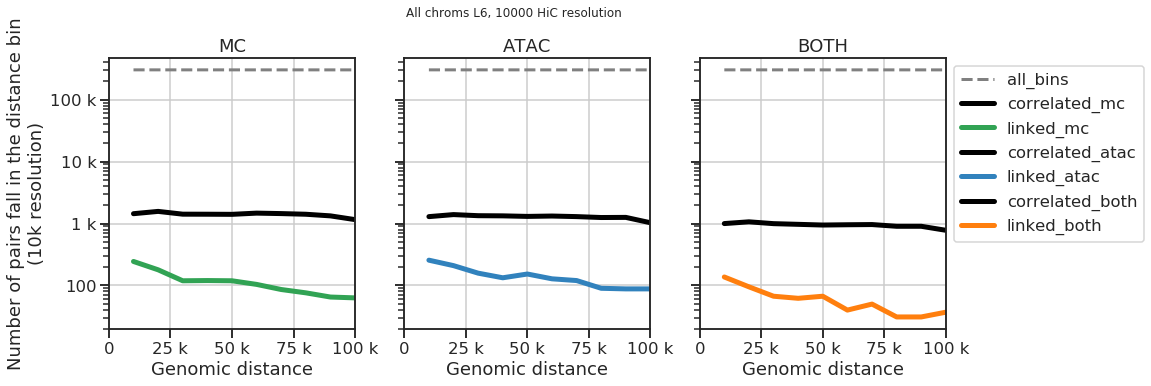

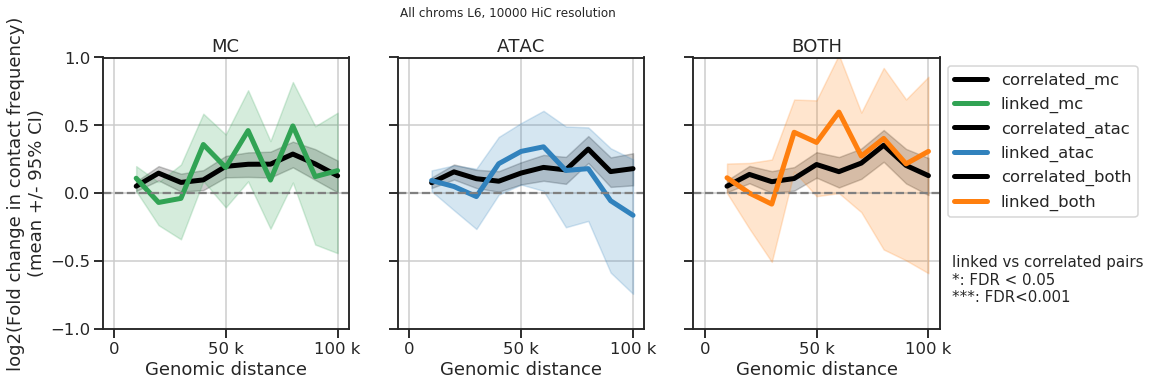

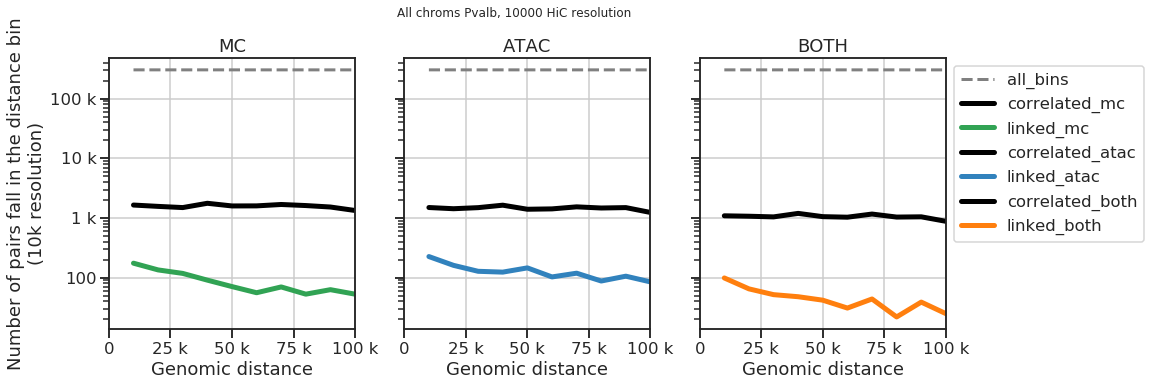

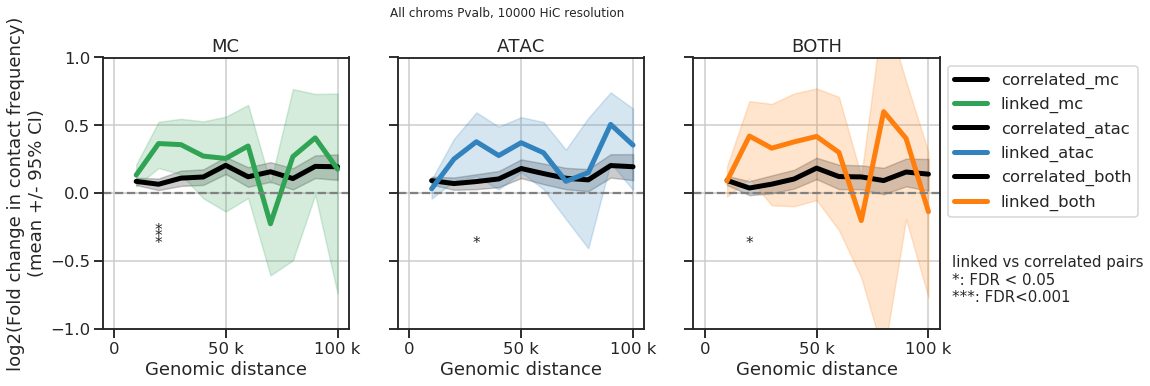

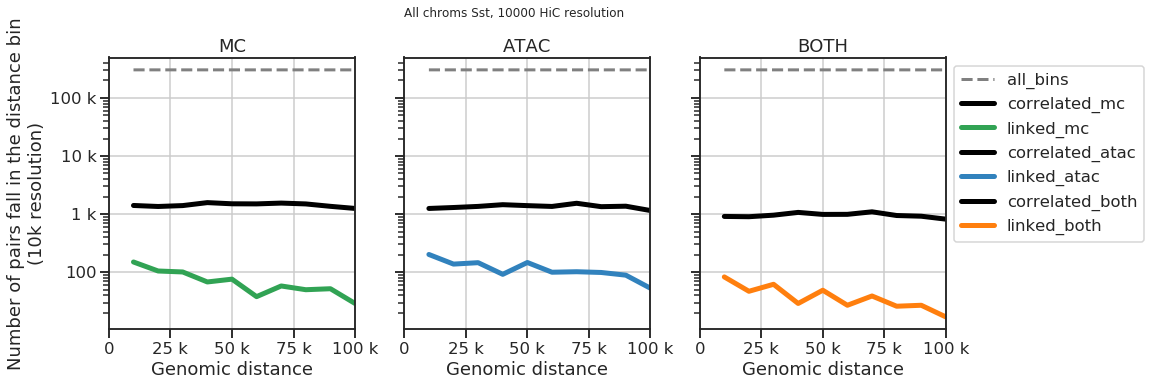

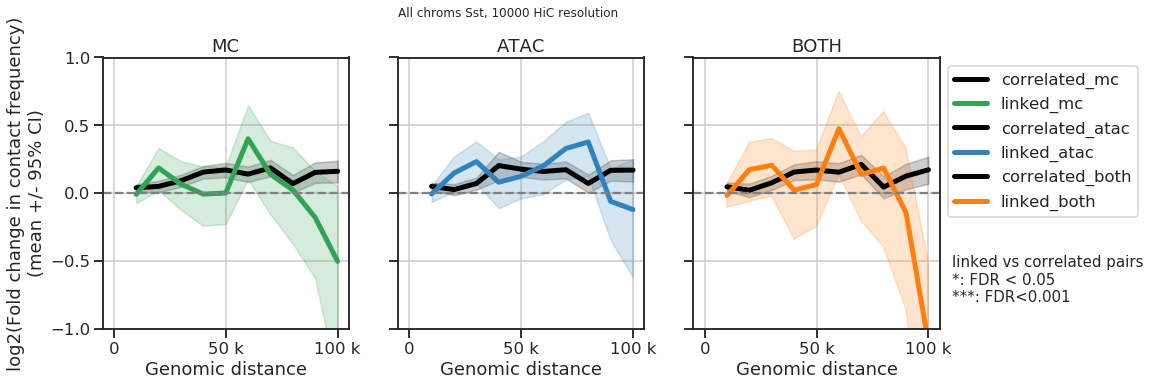

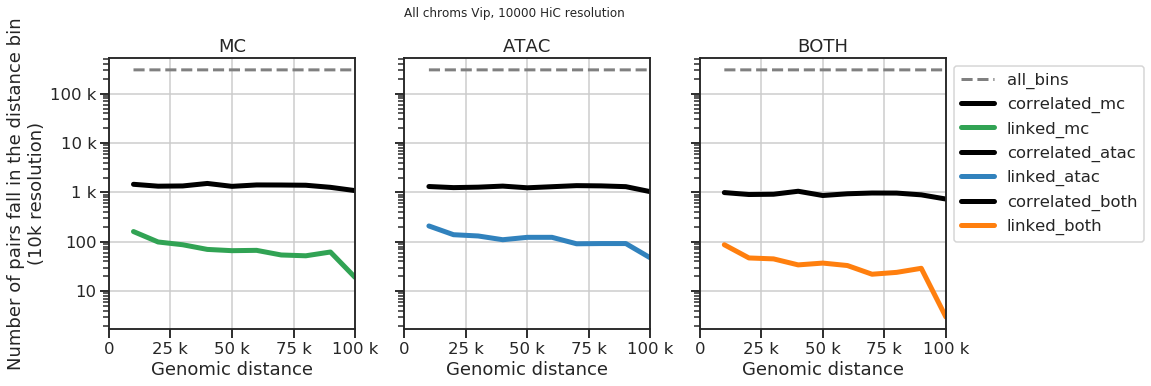

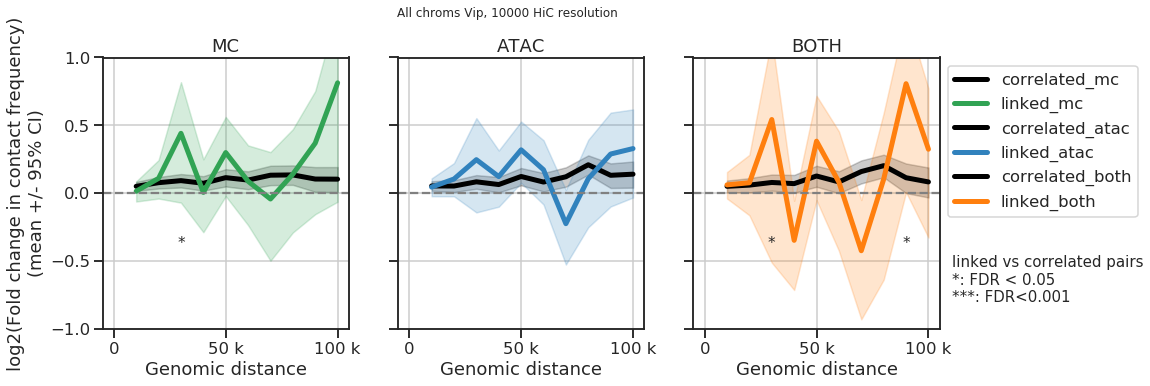

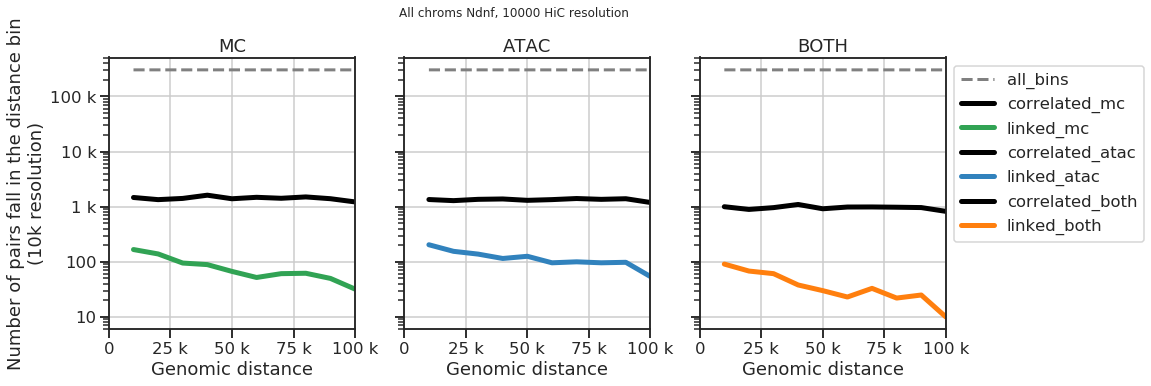

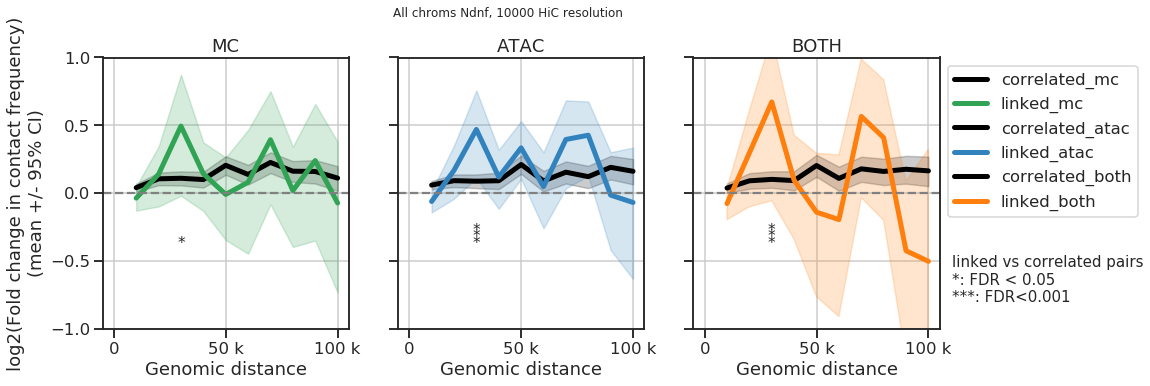

In [10]:
for celltype in celltypes:
    input_res = input_res_format.format(active_th, celltype, resolution, date)
    
    # get 
    with open(input_res, 'rb') as fh:
        (distances, 
         contacts_mean, contacts_std, contacts_n,
         contacts_sig_pairs_mean, 
         contacts_sig_pairs_std, 
         contacts_sig_pairs_n, 
        ) = pickle.load(fh)

    p_th1 = 0.05
    p_th2 = 0.001

    (mean_fcs_bck, padjs_bck, 
     mean_fcs_correlated, padjs_correlated,) = ttest_routine(contacts_mean, contacts_std, contacts_n, 
                                                              contacts_sig_pairs_mean,
                                                              contacts_sig_pairs_std,
                                                              contacts_sig_pairs_n,
                                                              p_th1=p_th1, p_th2=p_th2)
    
    output_fig = output_fig_format.format("{}_{}_plot1_v3_cov_test".format(celltype, resolution))
    plot1_v3_cov(distances, celltype, resolution, 
             track_names, track_palette, 
             contacts_mean, contacts_std, contacts_n, 
             contacts_sig_pairs_mean, contacts_sig_pairs_std, contacts_sig_pairs_n,
             output_fig,
             )

    output_fig = output_fig_format.format("{}_{}_plot1_v4_test".format(celltype, resolution))
    plot1_v4(distances, celltype, resolution, 
             track_names, track_palette, 
             contacts_mean, contacts_std, contacts_n, 
             contacts_sig_pairs_mean, contacts_sig_pairs_std, contacts_sig_pairs_n,
             padjs_correlated,
             output_fig,
              ylim=[-1, 1],
              yticks=[-1, -0.5, 0, 0.5, 1],
             )

# Summary 1: all celltypes

In [11]:
mean_fcs_bck_all = []
mean_fcs_correlated_all = []
padjs_bck_all = []
padjs_correlated_all = []

for celltype in celltypes:
    #
    input_res = input_res_format.format(active_th, celltype, resolution, date)

    # get 
    with open(input_res, 'rb') as fh:
        (distances, 
         contacts_mean, contacts_std, contacts_n,
         contacts_sig_pairs_mean, 
         contacts_sig_pairs_std, 
         contacts_sig_pairs_n, 
        ) = pickle.load(fh)

    p_th1 = 0.05
    p_th2 = 0.001

    # vs background
    mean_fcs_bck = collections.OrderedDict()
    padjs_bck = collections.OrderedDict()
    for key, item in contacts_sig_pairs_mean.items():
        # mean FC
        mean_fcs_bck[key] = item/contacts_mean

        # significance t-test
        t, p = stats.ttest_ind_from_stats(contacts_mean, contacts_std, contacts_n, 
                                          contacts_sig_pairs_mean[key],
                                          contacts_sig_pairs_std[key],
                                          contacts_sig_pairs_n[key],
                                          equal_var=True)
        # multiple comparison 
        _, padj, _, _ = multipletests(p, alpha=0.05, method='hs', is_sorted=False, returnsorted=False)

        # 
        padjs_bck[key] = padj

    # vs correlated
    mean_fcs_correlated = collections.OrderedDict()
    padjs_correlated = collections.OrderedDict()
    for key, item in contacts_sig_pairs_mean.items():
        if key.startswith('linked_'):
            # mean FC
            key_matched = key.replace('linked_', 'correlated_') 
            mean_fcs_correlated[key] = item/contacts_sig_pairs_mean[key_matched]

            # significance t-test
            t, p = stats.ttest_ind_from_stats( 
                                              contacts_sig_pairs_mean[key_matched],
                                              contacts_sig_pairs_std[key_matched],
                                              contacts_sig_pairs_n[key_matched],
                                              contacts_sig_pairs_mean[key],
                                              contacts_sig_pairs_std[key],
                                              contacts_sig_pairs_n[key],
                                              equal_var=True)
            # multiple comparison 
            _, padj, _, _ = multipletests(p, alpha=0.05, method='hs', is_sorted=False, returnsorted=False)

            # 
            padjs_correlated[key] = padj
    
    # ...
    
    mean_fcs_bck_all.append({'celltype': celltype, 'mean_fc': mean_fcs_bck,})
    mean_fcs_correlated_all.append({'celltype': celltype, 'mean_fc': mean_fcs_correlated,})
    padjs_bck_all.append({'celltype': celltype, 'mean_fc': padjs_bck,})
    padjs_correlated_all.append({'celltype': celltype, 'mean_fc': padjs_correlated,})
    
mean_fcs_bck_all = pd.DataFrame(mean_fcs_bck_all)
print(mean_fcs_bck_all.shape)

mean_fcs_correlated_all = pd.DataFrame(mean_fcs_correlated_all)
print(mean_fcs_correlated_all.shape)

padjs_bck_all = pd.DataFrame(padjs_bck_all)
print(padjs_bck_all.shape)

padjs_correlated_all = pd.DataFrame(padjs_correlated_all)
print(padjs_correlated_all.shape)
mean_fcs_bck_all.head()

(8, 2)
(8, 2)
(8, 2)
(8, 2)


celltype                                            mean_fc
0     L2_3  {'linked_mc': [1.01856581039, 0.975871763283, ...
1       L4  {'linked_mc': [1.00151771571, 1.13450933031, 1...
2       L5  {'linked_mc': [1.01989240545, 1.07380580632, 1...
3       L6  {'linked_mc': [1.08033703131, 0.954814458685, ...
4    Pvalb  {'linked_mc': [1.09797775205, 1.2894875485, 1....

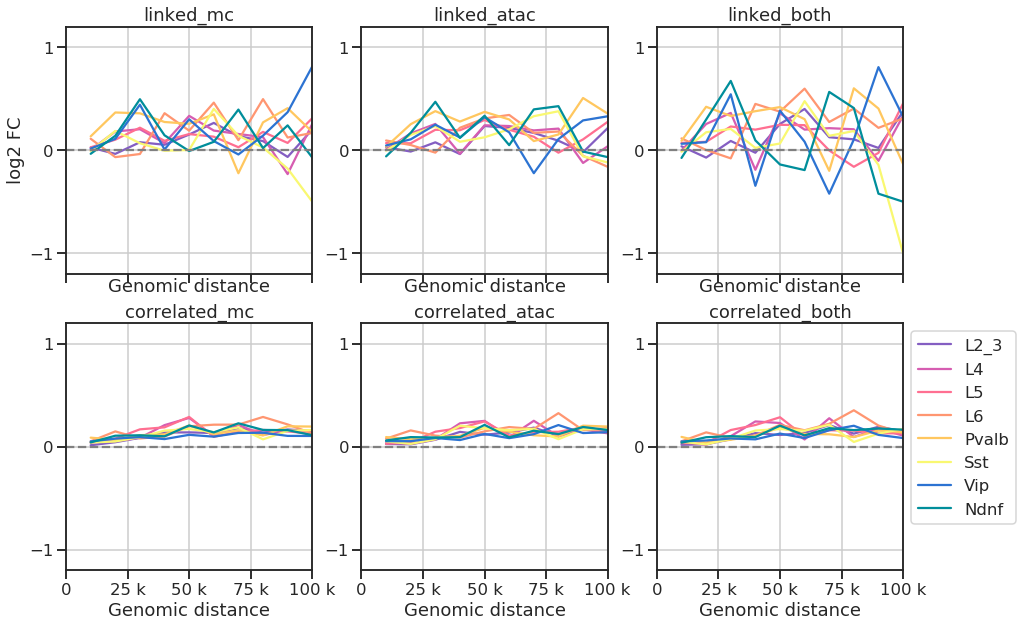

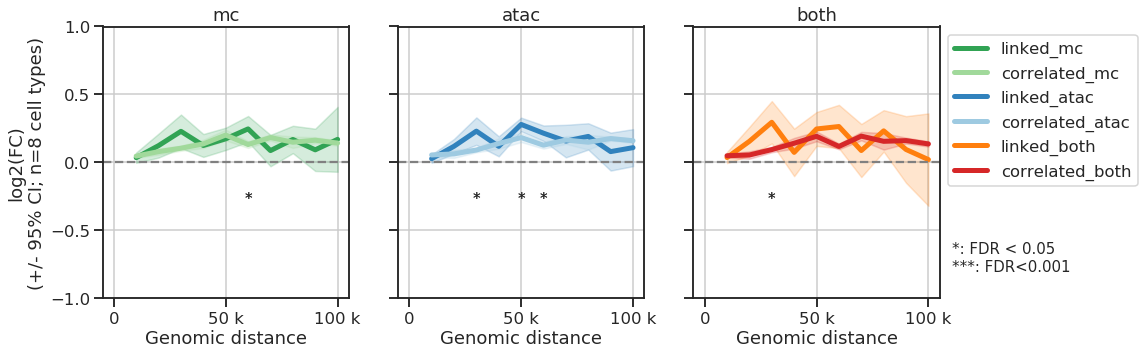

In [12]:
output_fig = output_fig_format.format("summarized_FC")
p_th = 0.05
plot2(distances, track_names, mean_fcs_bck_all, 
      celltype_palette, 
      output_fig, 
      ylim=[-1.2, 1.2],
      yticks=[-1, 0, 1],
     )

output_fig = output_fig_format.format("summarized_FC_v2")
plot3(distances, mean_fcs_bck_all, 
      track_names, track_palette,
      padjs_bck_all,
      output_fig, 
      ylim=[-1, 1],
      yticks=[-1, -0.5, 0, 0.5, 1],
     )

# Summary 2: combine all cell types into 1 track

- reconcile 8 different (mean, std, n)

In [13]:
# combine all cell types

contacts_mean_all = []
contacts_std_all = []
contacts_n_all = []

contacts_sig_pairs_mean_all = {track: [] for track in track_names}
contacts_sig_pairs_std_all = {track: [] for track in track_names}
contacts_sig_pairs_n_all = {track: [] for track in track_names}


for celltype in celltypes:
    input_res = input_res_format.format(active_th, celltype, resolution, date)
    
    # get 
    with open(input_res, 'rb') as fh:
        (distances, 
         contacts_mean, contacts_std, contacts_n,
         contacts_sig_pairs_mean, 
         contacts_sig_pairs_std, 
         contacts_sig_pairs_n, 
        ) = pickle.load(fh)

    # contacts: by regions -> celltype by regions -> by regions
    contacts_mean_all.append(contacts_mean)
    contacts_std_all.append(contacts_std)
    contacts_n_all.append(contacts_n)
    
    # contacts_sig_pairs: key by regions -> key by (celltype by regions) -> key by regions
    for key in contacts_sig_pairs_mean.keys():
        contacts_sig_pairs_mean_all[key].append(contacts_sig_pairs_mean[key])
        contacts_sig_pairs_std_all[key].append(contacts_sig_pairs_std[key])
        contacts_sig_pairs_n_all[key].append(contacts_sig_pairs_n[key])
    
# celltype by region 
contacts_mean_all = np.array(contacts_mean_all)
contacts_std_all = np.array(contacts_std_all)
contacts_n_all = np.array(contacts_n_all)
for key in contacts_sig_pairs_mean_all.keys():
    contacts_sig_pairs_mean_all[key] = np.array(contacts_sig_pairs_mean_all[key])
    contacts_sig_pairs_std_all[key] = np.array(contacts_sig_pairs_std_all[key])
    contacts_sig_pairs_n_all[key] = np.array(contacts_sig_pairs_n_all[key])

# by region
(contacts_mean_agg, contacts_std_agg, contacts_n_agg,
) = aggregate_mean_std_matrix(contacts_mean_all, contacts_std_all, contacts_n_all)
 
# key by region
contacts_sig_pairs_mean_agg = {track: [] for track in track_names}
contacts_sig_pairs_std_agg = {track: [] for track in track_names}
contacts_sig_pairs_n_agg = {track: [] for track in track_names}
for key in contacts_sig_pairs_mean_all.keys():
    (contacts_sig_pairs_mean_agg[key], 
     contacts_sig_pairs_std_agg[key], 
     contacts_sig_pairs_n_agg[key], 
    ) = aggregate_mean_std_matrix(contacts_sig_pairs_mean_all[key], 
                                  contacts_sig_pairs_std_all[key], 
                                  contacts_sig_pairs_n_all[key], 
                                 )
    
p_th1 = 0.05
p_th2 = 0.001
(mean_fcs_bck, padjs_bck, 
 mean_fcs_correlated, padjs_correlated,) = ttest_routine(contacts_mean_agg, 
                                                         contacts_std_agg, 
                                                         contacts_n_agg, 
                                                         contacts_sig_pairs_mean_agg,
                                                         contacts_sig_pairs_std_agg,
                                                         contacts_sig_pairs_n_agg,
                                                         p_th1=p_th1, p_th2=p_th2)

/cndd2/fangming/sphere_old/enhancers/scripts/figures/hic_contact_enrichment_metacell_liftover0.80_celltypespec_agg_8celltypes_10000_plot1_v3.pdf.pdf


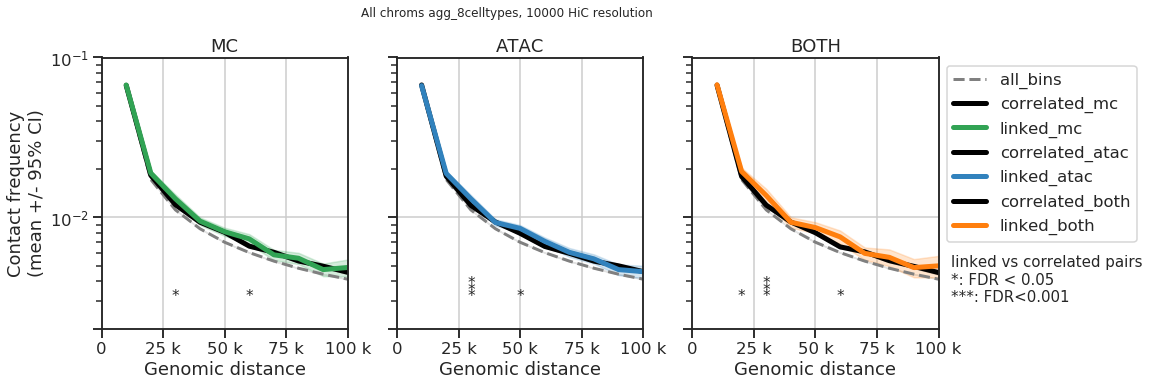

/cndd2/fangming/sphere_old/enhancers/scripts/figures/hic_contact_enrichment_metacell_liftover0.80_celltypespec_agg_8celltypes_10000_plot1_v4.pdf.pdf


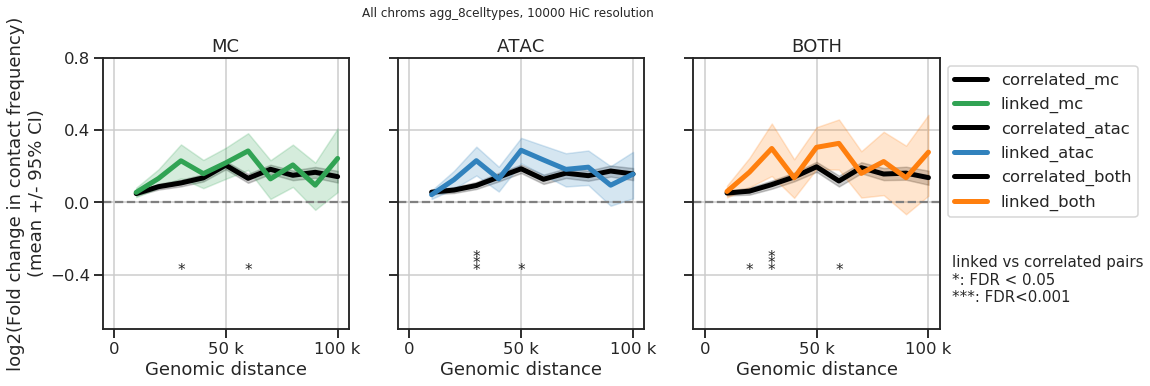

/cndd2/fangming/sphere_old/enhancers/scripts/figures/hic_contact_enrichment_metacell_liftover0.80_celltypespec_agg_8celltypes_10000_plot1_v3_cov_test.pdf.pdf


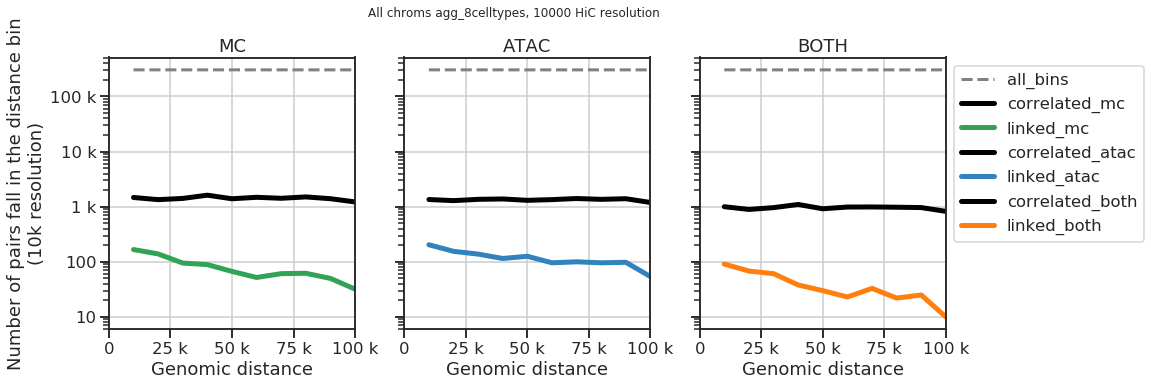

In [14]:
celltype = 'agg_8celltypes'

output_fig = output_fig_format.format('{}_{}_plot1_v3.pdf'.format(celltype, resolution))
print(output_fig)
plot1_v3(distances, celltype, resolution, 
         track_names, track_palette, 
         contacts_mean_agg, contacts_std_agg, contacts_n_agg, 
         contacts_sig_pairs_mean_agg, contacts_sig_pairs_std_agg, contacts_sig_pairs_n_agg,
         padjs_correlated,
         output_fig,
         ylim=[2e-3, 1e-1],
         yticks=[2e-3, 1e-2, 1e-1,],
         )

output_fig = output_fig_format.format('{}_{}_plot1_v4.pdf'.format(celltype, resolution))
print(output_fig)
plot1_v4(distances, celltype, resolution, 
         track_names, track_palette, 
         contacts_mean_agg, contacts_std_agg, contacts_n_agg, 
         contacts_sig_pairs_mean_agg, contacts_sig_pairs_std_agg, contacts_sig_pairs_n_agg,
         padjs_correlated,
         output_fig,
         ylim=[-0.7, 0.8],
         yticks=[-0.4, 0, 0.4, 0.8],
         )

output_fig = output_fig_format.format('{}_{}_plot1_v3_cov_test.pdf'.format(celltype, resolution))
print(output_fig)
plot1_v3_cov(distances, celltype, resolution, 
         track_names, track_palette, 
         contacts_mean, contacts_std, contacts_n, 
         contacts_sig_pairs_mean, contacts_sig_pairs_std, contacts_sig_pairs_n,
         output_fig,
         )

# apply summary 2 to all thresholds

In [15]:
min_matches = np.arange(0.1, 1+0.05, 0.05)
print(min_matches)

[ 0.1   0.15  0.2   0.25  0.3   0.35  0.4   0.45  0.5   0.55  0.6   0.65
  0.7   0.75  0.8   0.85  0.9   0.95  1.  ]


0.1
/cndd2/fangming/sphere_old/enhancers/scripts/results_new/hic_contact_enrichment_metacell_liftover0.10_celltypespec_{}_{}_{}_{}.pkl
/cndd2/fangming/sphere_old/enhancers/scripts/figures/hic_contact_enrichment_metacell_liftover0.10_celltypespec_{}.pdf
/cndd2/fangming/sphere_old/enhancers/scripts/figures/hic_contact_enrichment_metacell_liftover0.10_celltypespec_agg_8celltypes_10000_plot1_v4.pdf.pdf


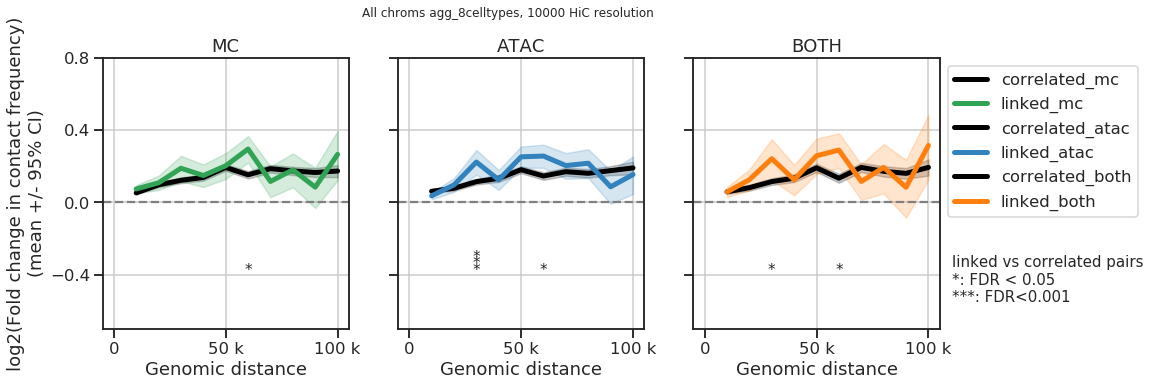

/cndd2/fangming/sphere_old/enhancers/scripts/figures/hic_contact_enrichment_metacell_liftover0.10_celltypespec_agg_8celltypes_10000_plot1_v3_cov_test.pdf.pdf


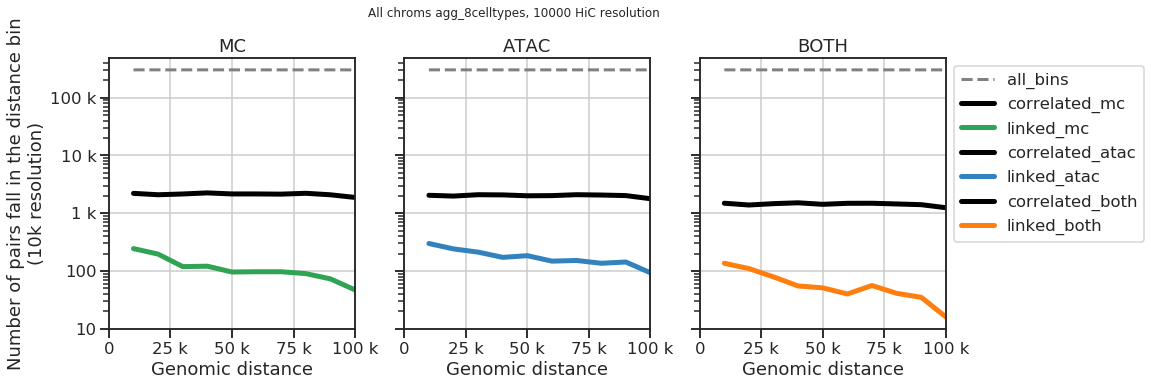

0.15
/cndd2/fangming/sphere_old/enhancers/scripts/results_new/hic_contact_enrichment_metacell_liftover0.15_celltypespec_{}_{}_{}_{}.pkl
/cndd2/fangming/sphere_old/enhancers/scripts/figures/hic_contact_enrichment_metacell_liftover0.15_celltypespec_{}.pdf
/cndd2/fangming/sphere_old/enhancers/scripts/figures/hic_contact_enrichment_metacell_liftover0.15_celltypespec_agg_8celltypes_10000_plot1_v4.pdf.pdf


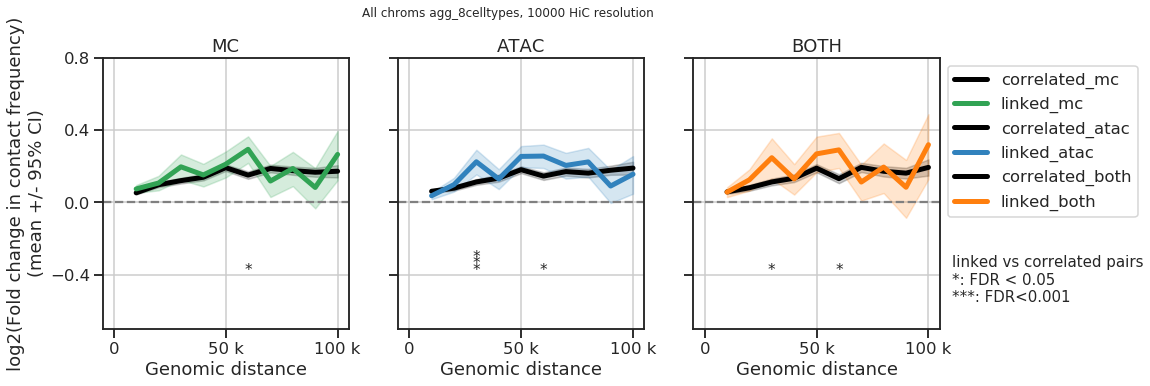

/cndd2/fangming/sphere_old/enhancers/scripts/figures/hic_contact_enrichment_metacell_liftover0.15_celltypespec_agg_8celltypes_10000_plot1_v3_cov_test.pdf.pdf


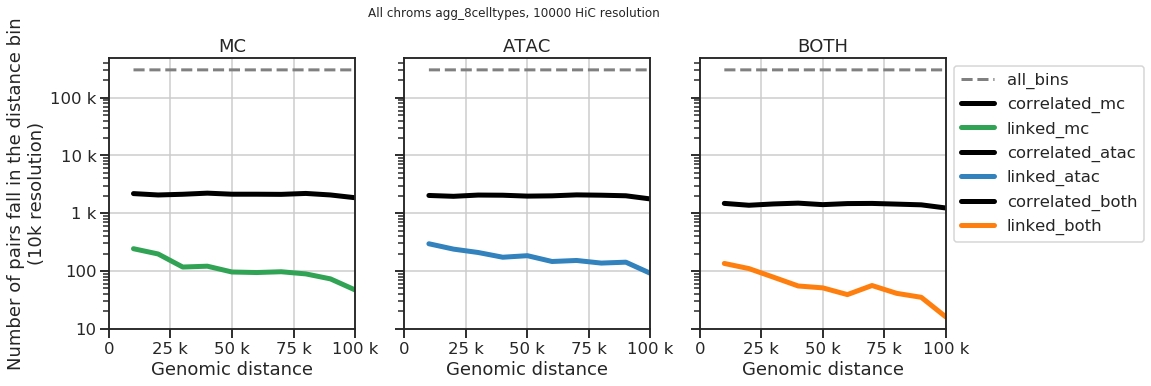

0.2
/cndd2/fangming/sphere_old/enhancers/scripts/results_new/hic_contact_enrichment_metacell_liftover0.20_celltypespec_{}_{}_{}_{}.pkl
/cndd2/fangming/sphere_old/enhancers/scripts/figures/hic_contact_enrichment_metacell_liftover0.20_celltypespec_{}.pdf
/cndd2/fangming/sphere_old/enhancers/scripts/figures/hic_contact_enrichment_metacell_liftover0.20_celltypespec_agg_8celltypes_10000_plot1_v4.pdf.pdf


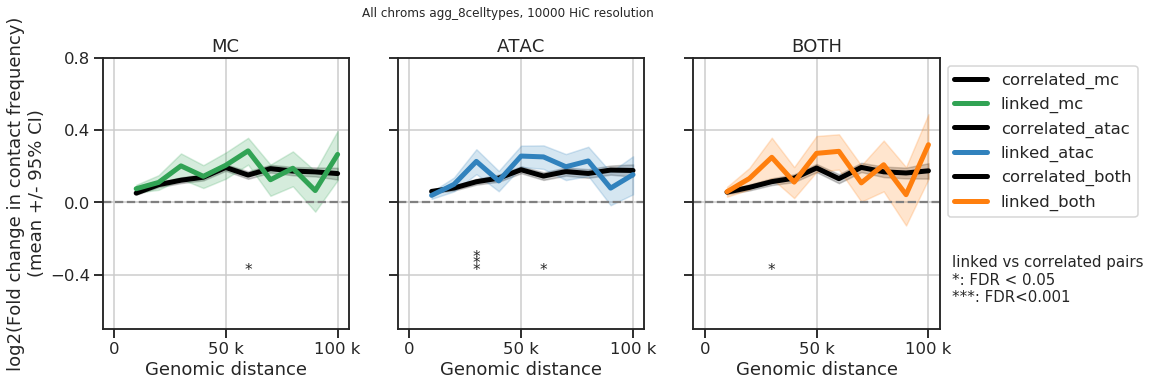

/cndd2/fangming/sphere_old/enhancers/scripts/figures/hic_contact_enrichment_metacell_liftover0.20_celltypespec_agg_8celltypes_10000_plot1_v3_cov_test.pdf.pdf


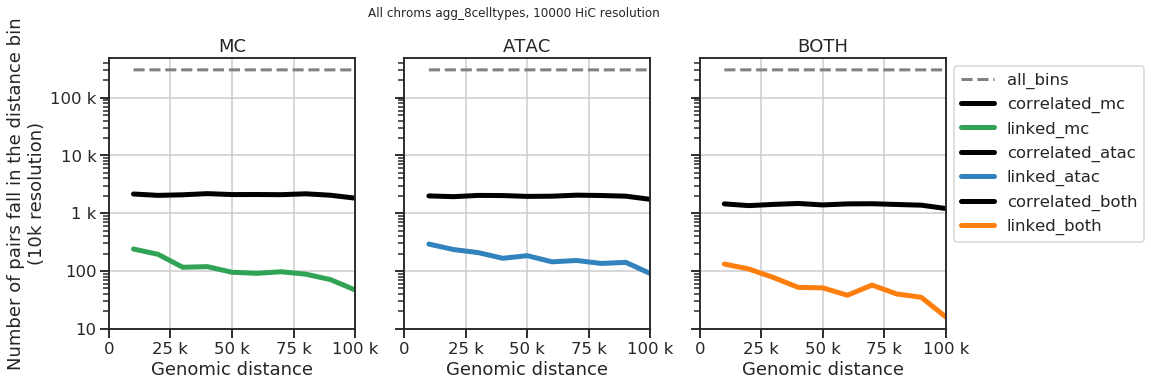

0.25
/cndd2/fangming/sphere_old/enhancers/scripts/results_new/hic_contact_enrichment_metacell_liftover0.25_celltypespec_{}_{}_{}_{}.pkl
/cndd2/fangming/sphere_old/enhancers/scripts/figures/hic_contact_enrichment_metacell_liftover0.25_celltypespec_{}.pdf
/cndd2/fangming/sphere_old/enhancers/scripts/figures/hic_contact_enrichment_metacell_liftover0.25_celltypespec_agg_8celltypes_10000_plot1_v4.pdf.pdf


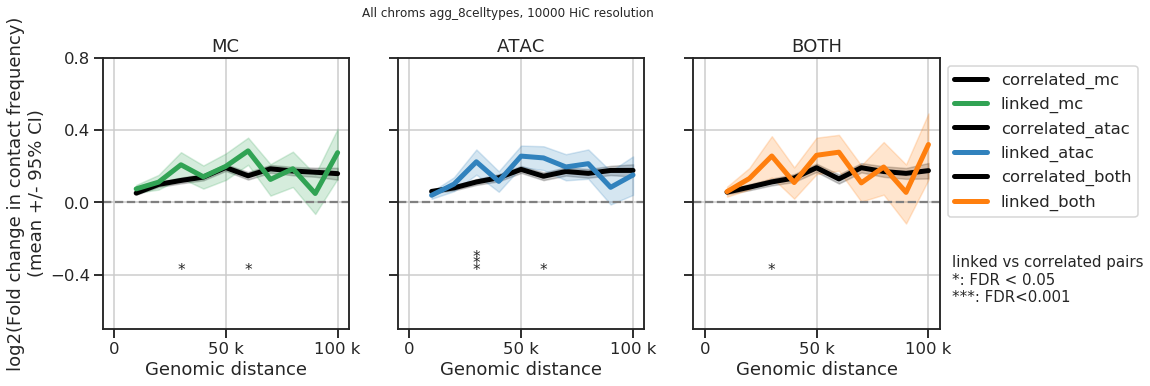

/cndd2/fangming/sphere_old/enhancers/scripts/figures/hic_contact_enrichment_metacell_liftover0.25_celltypespec_agg_8celltypes_10000_plot1_v3_cov_test.pdf.pdf


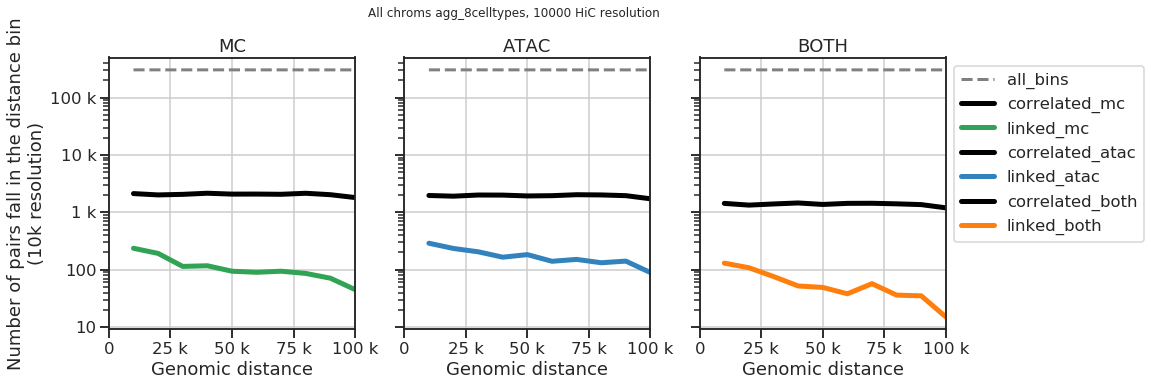

0.3
/cndd2/fangming/sphere_old/enhancers/scripts/results_new/hic_contact_enrichment_metacell_liftover0.30_celltypespec_{}_{}_{}_{}.pkl
/cndd2/fangming/sphere_old/enhancers/scripts/figures/hic_contact_enrichment_metacell_liftover0.30_celltypespec_{}.pdf
/cndd2/fangming/sphere_old/enhancers/scripts/figures/hic_contact_enrichment_metacell_liftover0.30_celltypespec_agg_8celltypes_10000_plot1_v4.pdf.pdf


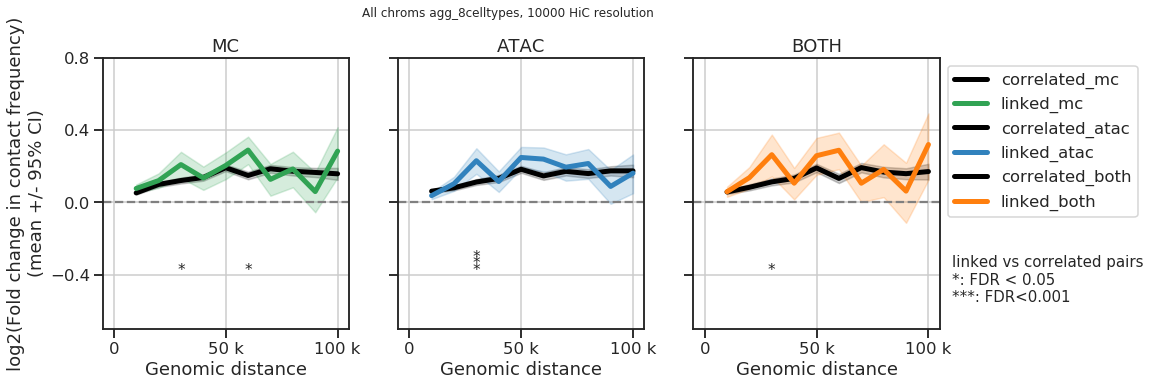

/cndd2/fangming/sphere_old/enhancers/scripts/figures/hic_contact_enrichment_metacell_liftover0.30_celltypespec_agg_8celltypes_10000_plot1_v3_cov_test.pdf.pdf


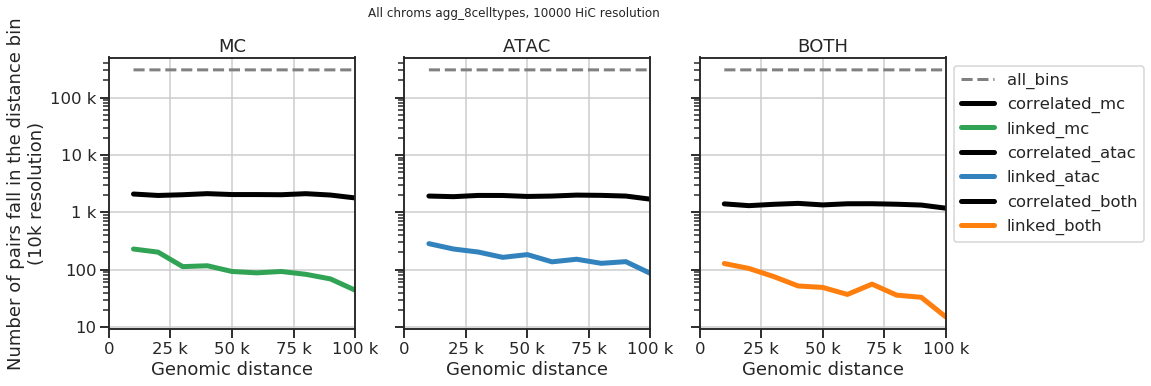

0.35
/cndd2/fangming/sphere_old/enhancers/scripts/results_new/hic_contact_enrichment_metacell_liftover0.35_celltypespec_{}_{}_{}_{}.pkl
/cndd2/fangming/sphere_old/enhancers/scripts/figures/hic_contact_enrichment_metacell_liftover0.35_celltypespec_{}.pdf
/cndd2/fangming/sphere_old/enhancers/scripts/figures/hic_contact_enrichment_metacell_liftover0.35_celltypespec_agg_8celltypes_10000_plot1_v4.pdf.pdf


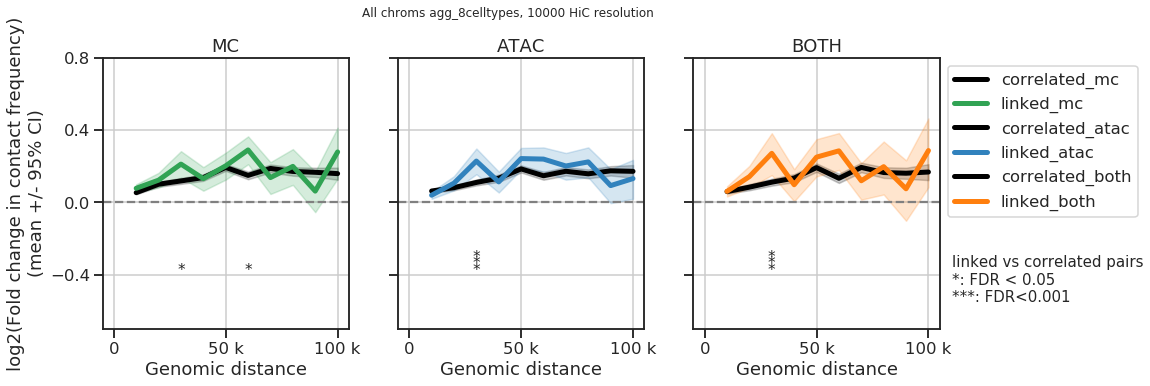

/cndd2/fangming/sphere_old/enhancers/scripts/figures/hic_contact_enrichment_metacell_liftover0.35_celltypespec_agg_8celltypes_10000_plot1_v3_cov_test.pdf.pdf


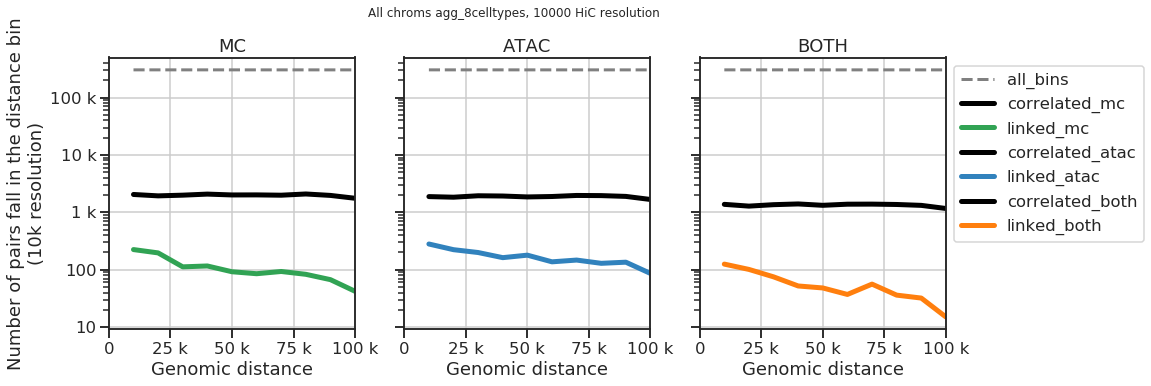

0.4
/cndd2/fangming/sphere_old/enhancers/scripts/results_new/hic_contact_enrichment_metacell_liftover0.40_celltypespec_{}_{}_{}_{}.pkl
/cndd2/fangming/sphere_old/enhancers/scripts/figures/hic_contact_enrichment_metacell_liftover0.40_celltypespec_{}.pdf
/cndd2/fangming/sphere_old/enhancers/scripts/figures/hic_contact_enrichment_metacell_liftover0.40_celltypespec_agg_8celltypes_10000_plot1_v4.pdf.pdf


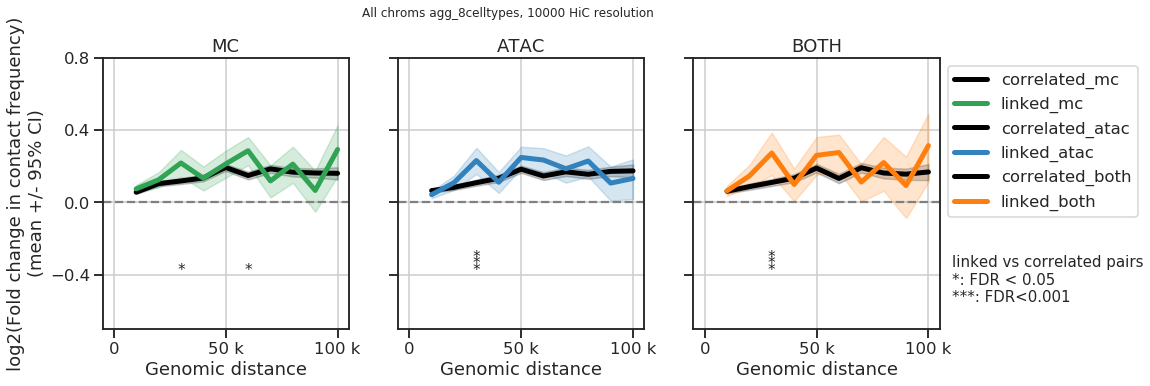

/cndd2/fangming/sphere_old/enhancers/scripts/figures/hic_contact_enrichment_metacell_liftover0.40_celltypespec_agg_8celltypes_10000_plot1_v3_cov_test.pdf.pdf


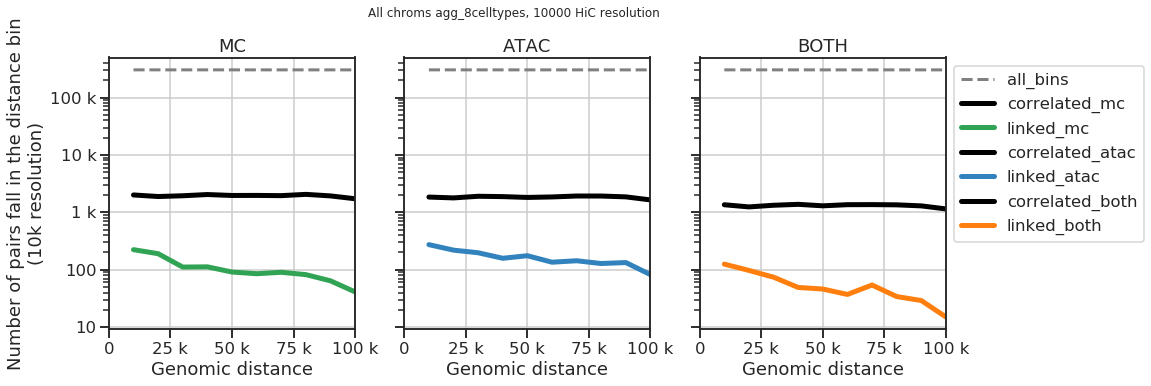

0.45
/cndd2/fangming/sphere_old/enhancers/scripts/results_new/hic_contact_enrichment_metacell_liftover0.45_celltypespec_{}_{}_{}_{}.pkl
/cndd2/fangming/sphere_old/enhancers/scripts/figures/hic_contact_enrichment_metacell_liftover0.45_celltypespec_{}.pdf
/cndd2/fangming/sphere_old/enhancers/scripts/figures/hic_contact_enrichment_metacell_liftover0.45_celltypespec_agg_8celltypes_10000_plot1_v4.pdf.pdf


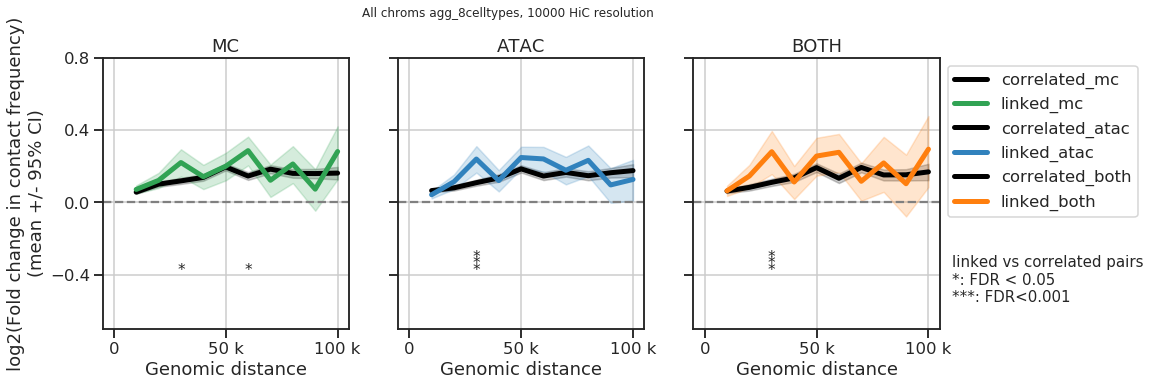

/cndd2/fangming/sphere_old/enhancers/scripts/figures/hic_contact_enrichment_metacell_liftover0.45_celltypespec_agg_8celltypes_10000_plot1_v3_cov_test.pdf.pdf


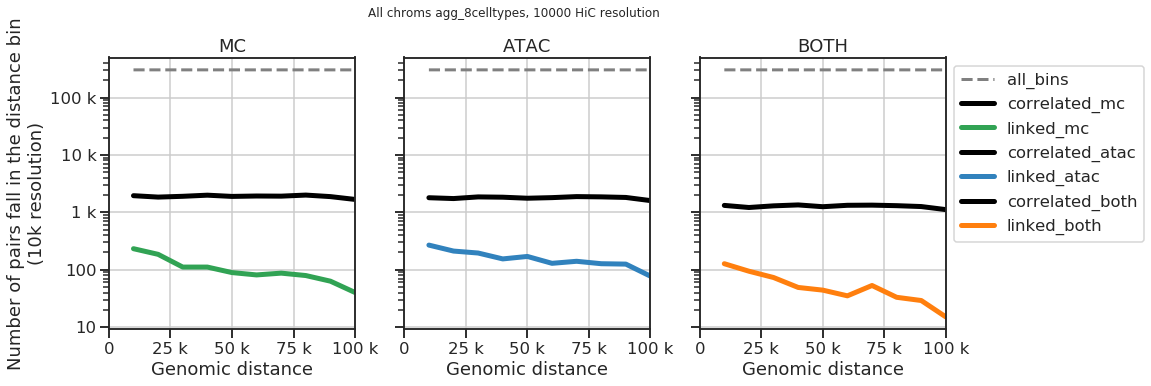

0.5
/cndd2/fangming/sphere_old/enhancers/scripts/results_new/hic_contact_enrichment_metacell_liftover0.50_celltypespec_{}_{}_{}_{}.pkl
/cndd2/fangming/sphere_old/enhancers/scripts/figures/hic_contact_enrichment_metacell_liftover0.50_celltypespec_{}.pdf
/cndd2/fangming/sphere_old/enhancers/scripts/figures/hic_contact_enrichment_metacell_liftover0.50_celltypespec_agg_8celltypes_10000_plot1_v4.pdf.pdf


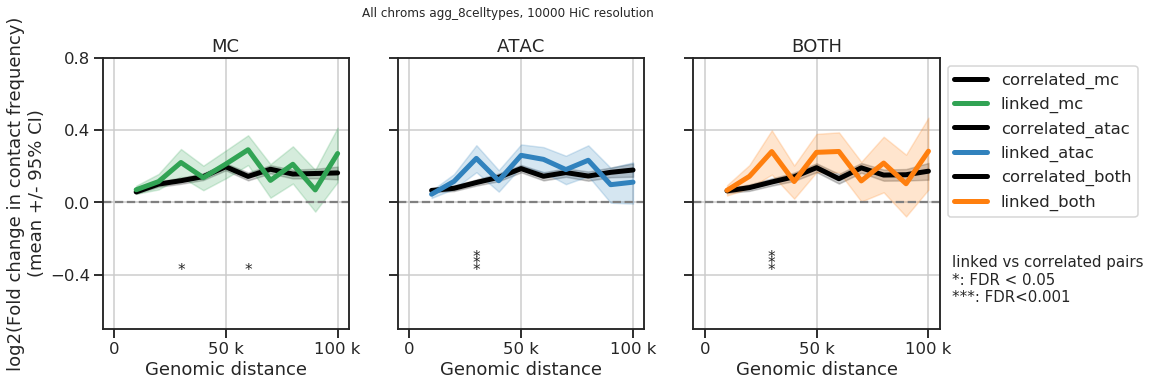

/cndd2/fangming/sphere_old/enhancers/scripts/figures/hic_contact_enrichment_metacell_liftover0.50_celltypespec_agg_8celltypes_10000_plot1_v3_cov_test.pdf.pdf


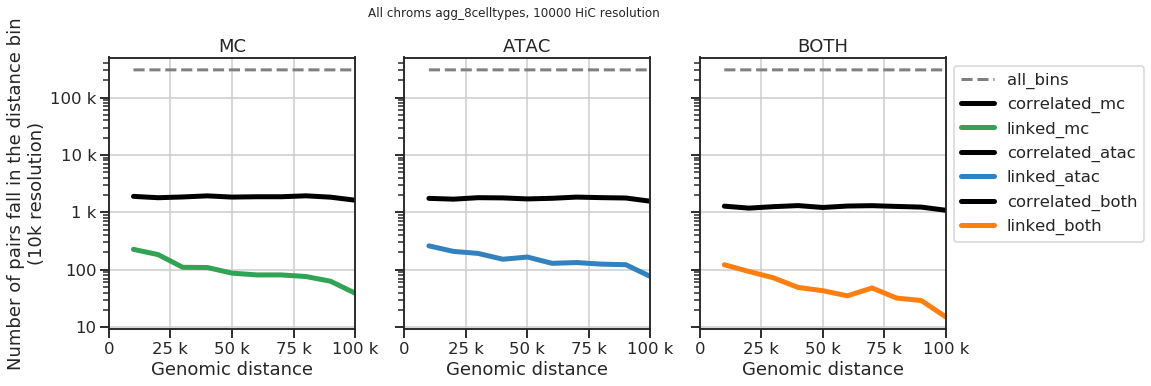

0.55
/cndd2/fangming/sphere_old/enhancers/scripts/results_new/hic_contact_enrichment_metacell_liftover0.55_celltypespec_{}_{}_{}_{}.pkl
/cndd2/fangming/sphere_old/enhancers/scripts/figures/hic_contact_enrichment_metacell_liftover0.55_celltypespec_{}.pdf
/cndd2/fangming/sphere_old/enhancers/scripts/figures/hic_contact_enrichment_metacell_liftover0.55_celltypespec_agg_8celltypes_10000_plot1_v4.pdf.pdf


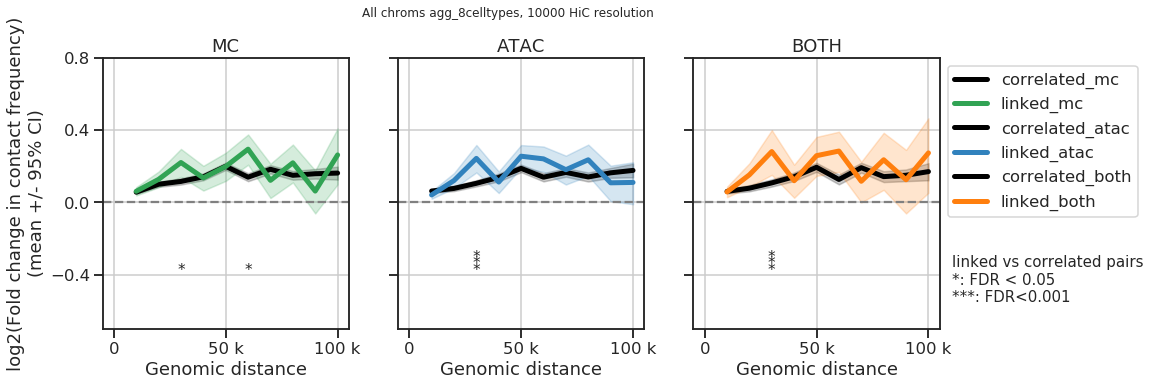

/cndd2/fangming/sphere_old/enhancers/scripts/figures/hic_contact_enrichment_metacell_liftover0.55_celltypespec_agg_8celltypes_10000_plot1_v3_cov_test.pdf.pdf


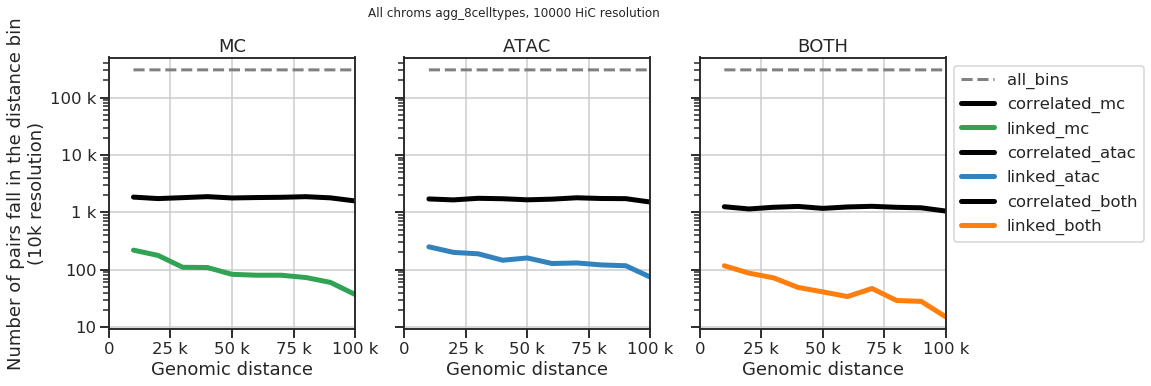

0.6
/cndd2/fangming/sphere_old/enhancers/scripts/results_new/hic_contact_enrichment_metacell_liftover0.60_celltypespec_{}_{}_{}_{}.pkl
/cndd2/fangming/sphere_old/enhancers/scripts/figures/hic_contact_enrichment_metacell_liftover0.60_celltypespec_{}.pdf
/cndd2/fangming/sphere_old/enhancers/scripts/figures/hic_contact_enrichment_metacell_liftover0.60_celltypespec_agg_8celltypes_10000_plot1_v4.pdf.pdf


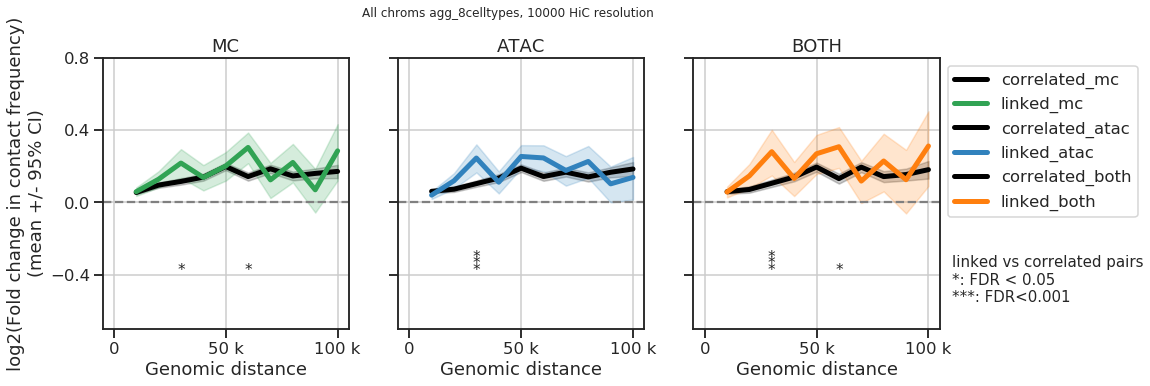

/cndd2/fangming/sphere_old/enhancers/scripts/figures/hic_contact_enrichment_metacell_liftover0.60_celltypespec_agg_8celltypes_10000_plot1_v3_cov_test.pdf.pdf


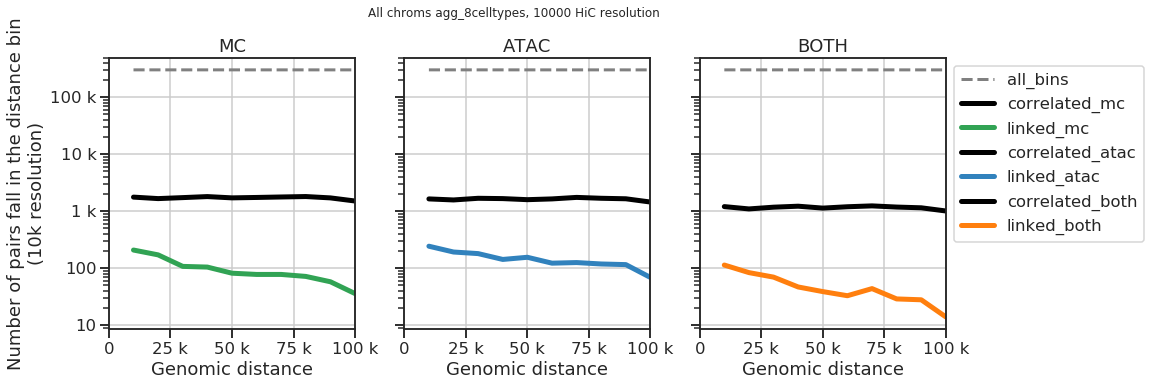

0.65
/cndd2/fangming/sphere_old/enhancers/scripts/results_new/hic_contact_enrichment_metacell_liftover0.65_celltypespec_{}_{}_{}_{}.pkl
/cndd2/fangming/sphere_old/enhancers/scripts/figures/hic_contact_enrichment_metacell_liftover0.65_celltypespec_{}.pdf
/cndd2/fangming/sphere_old/enhancers/scripts/figures/hic_contact_enrichment_metacell_liftover0.65_celltypespec_agg_8celltypes_10000_plot1_v4.pdf.pdf


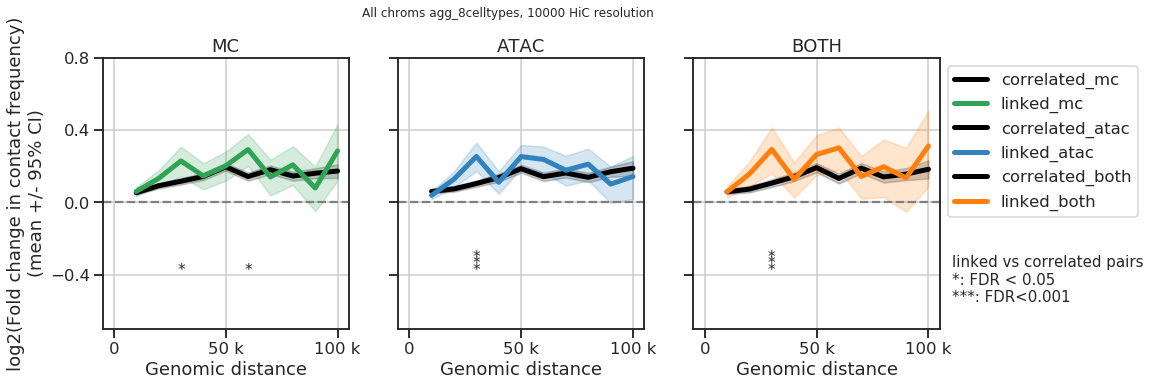

/cndd2/fangming/sphere_old/enhancers/scripts/figures/hic_contact_enrichment_metacell_liftover0.65_celltypespec_agg_8celltypes_10000_plot1_v3_cov_test.pdf.pdf


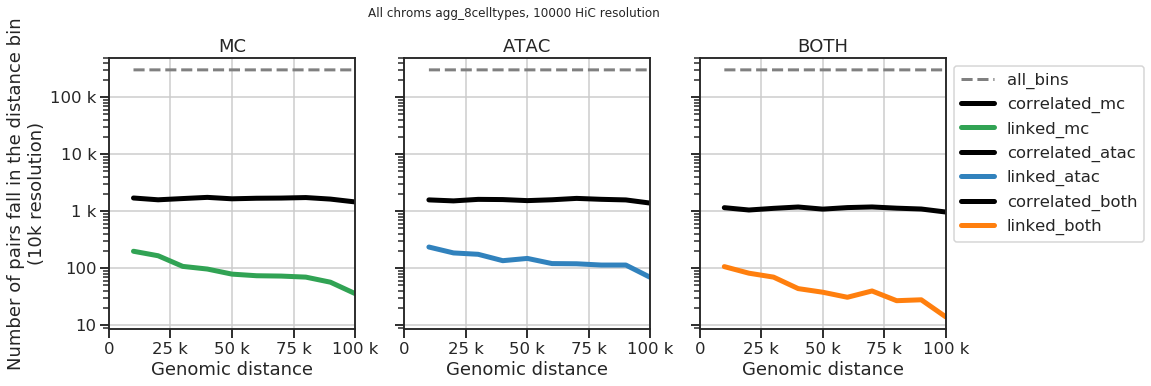

0.7
/cndd2/fangming/sphere_old/enhancers/scripts/results_new/hic_contact_enrichment_metacell_liftover0.70_celltypespec_{}_{}_{}_{}.pkl
/cndd2/fangming/sphere_old/enhancers/scripts/figures/hic_contact_enrichment_metacell_liftover0.70_celltypespec_{}.pdf
/cndd2/fangming/sphere_old/enhancers/scripts/figures/hic_contact_enrichment_metacell_liftover0.70_celltypespec_agg_8celltypes_10000_plot1_v4.pdf.pdf


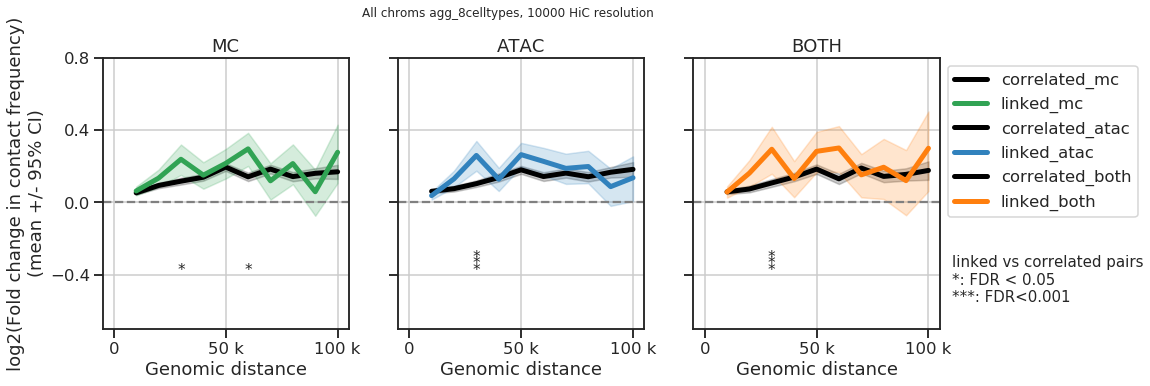

/cndd2/fangming/sphere_old/enhancers/scripts/figures/hic_contact_enrichment_metacell_liftover0.70_celltypespec_agg_8celltypes_10000_plot1_v3_cov_test.pdf.pdf


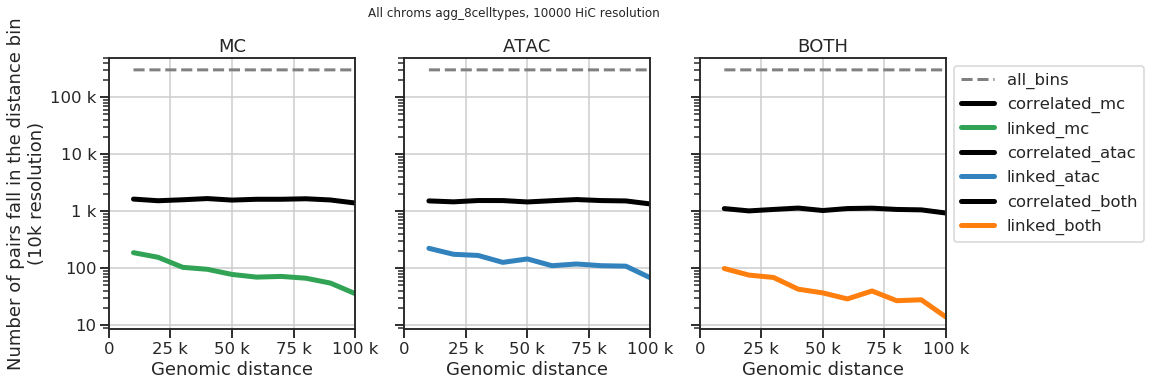

0.75
/cndd2/fangming/sphere_old/enhancers/scripts/results_new/hic_contact_enrichment_metacell_liftover0.75_celltypespec_{}_{}_{}_{}.pkl
/cndd2/fangming/sphere_old/enhancers/scripts/figures/hic_contact_enrichment_metacell_liftover0.75_celltypespec_{}.pdf
/cndd2/fangming/sphere_old/enhancers/scripts/figures/hic_contact_enrichment_metacell_liftover0.75_celltypespec_agg_8celltypes_10000_plot1_v4.pdf.pdf


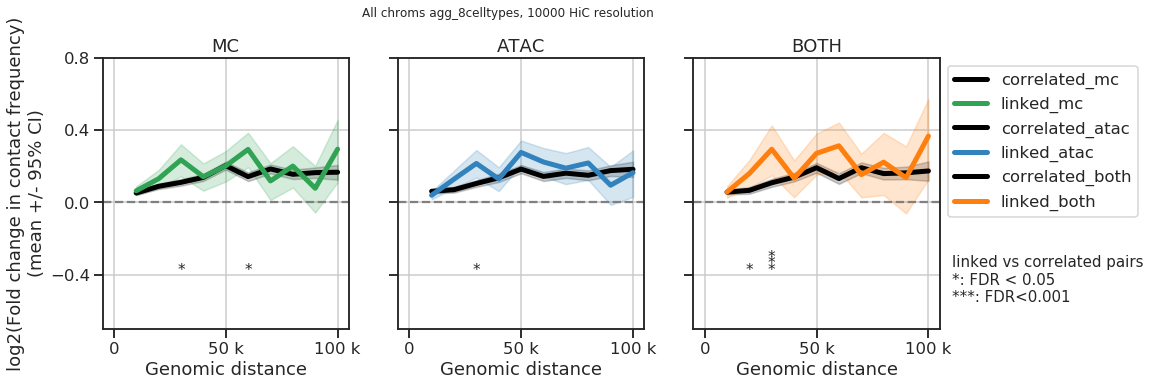

/cndd2/fangming/sphere_old/enhancers/scripts/figures/hic_contact_enrichment_metacell_liftover0.75_celltypespec_agg_8celltypes_10000_plot1_v3_cov_test.pdf.pdf


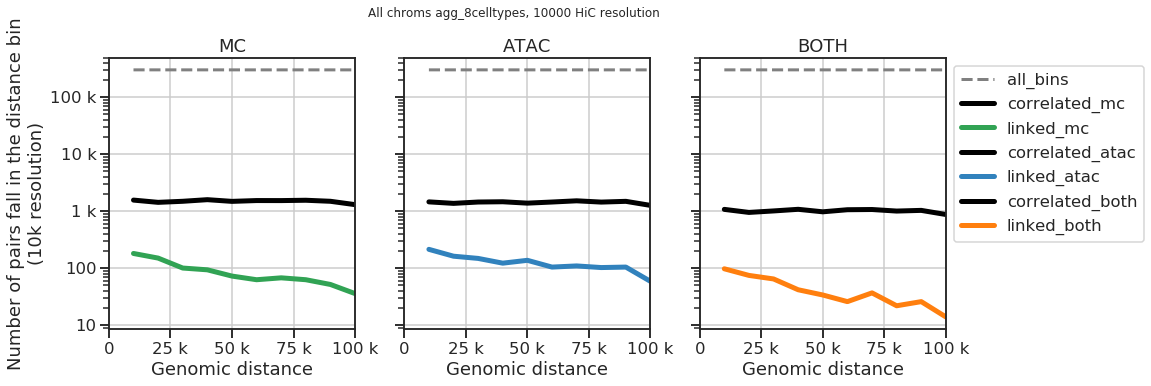

0.8
/cndd2/fangming/sphere_old/enhancers/scripts/results_new/hic_contact_enrichment_metacell_liftover0.80_celltypespec_{}_{}_{}_{}.pkl
/cndd2/fangming/sphere_old/enhancers/scripts/figures/hic_contact_enrichment_metacell_liftover0.80_celltypespec_{}.pdf
/cndd2/fangming/sphere_old/enhancers/scripts/figures/hic_contact_enrichment_metacell_liftover0.80_celltypespec_agg_8celltypes_10000_plot1_v4.pdf.pdf


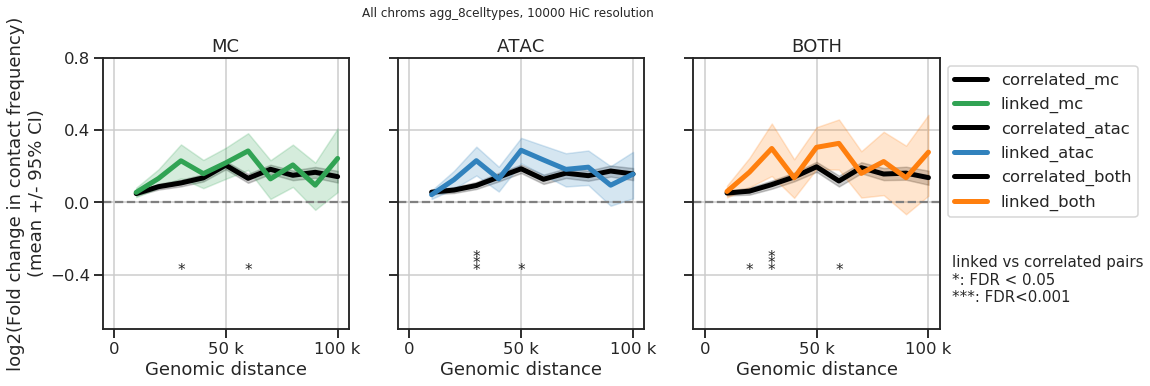

/cndd2/fangming/sphere_old/enhancers/scripts/figures/hic_contact_enrichment_metacell_liftover0.80_celltypespec_agg_8celltypes_10000_plot1_v3_cov_test.pdf.pdf


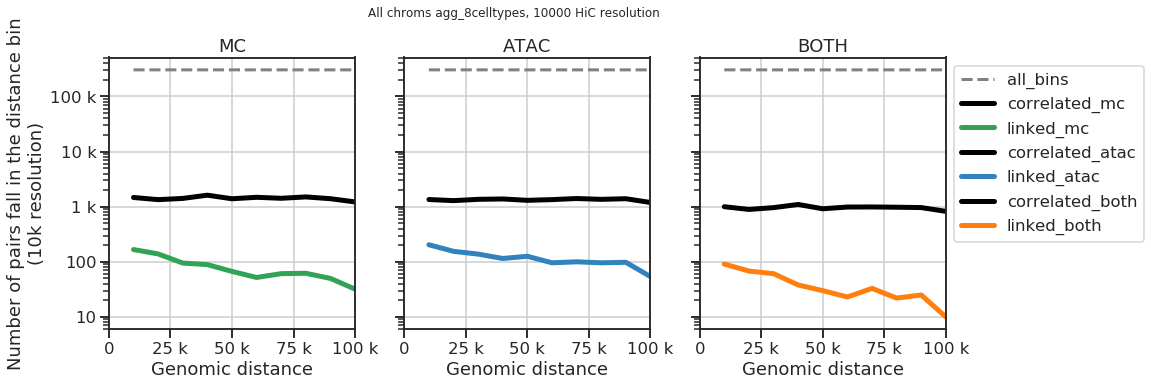

0.85
/cndd2/fangming/sphere_old/enhancers/scripts/results_new/hic_contact_enrichment_metacell_liftover0.85_celltypespec_{}_{}_{}_{}.pkl
/cndd2/fangming/sphere_old/enhancers/scripts/figures/hic_contact_enrichment_metacell_liftover0.85_celltypespec_{}.pdf
/cndd2/fangming/sphere_old/enhancers/scripts/figures/hic_contact_enrichment_metacell_liftover0.85_celltypespec_agg_8celltypes_10000_plot1_v4.pdf.pdf


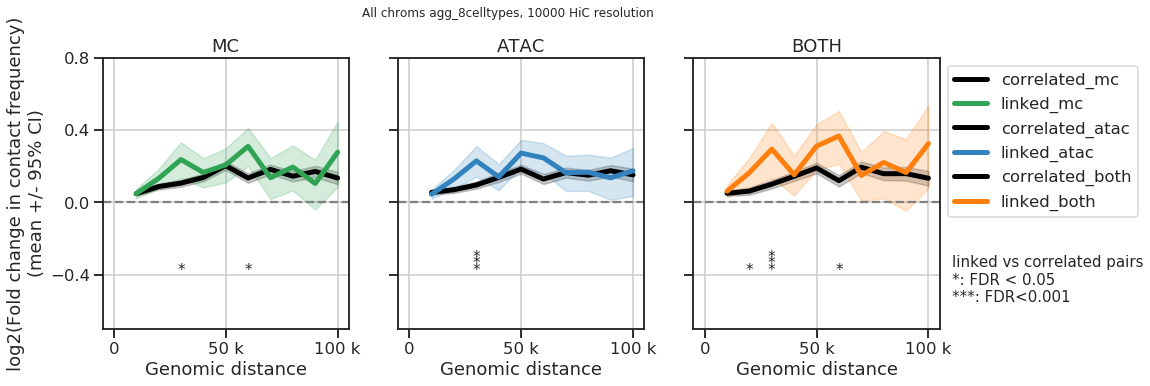

/cndd2/fangming/sphere_old/enhancers/scripts/figures/hic_contact_enrichment_metacell_liftover0.85_celltypespec_agg_8celltypes_10000_plot1_v3_cov_test.pdf.pdf


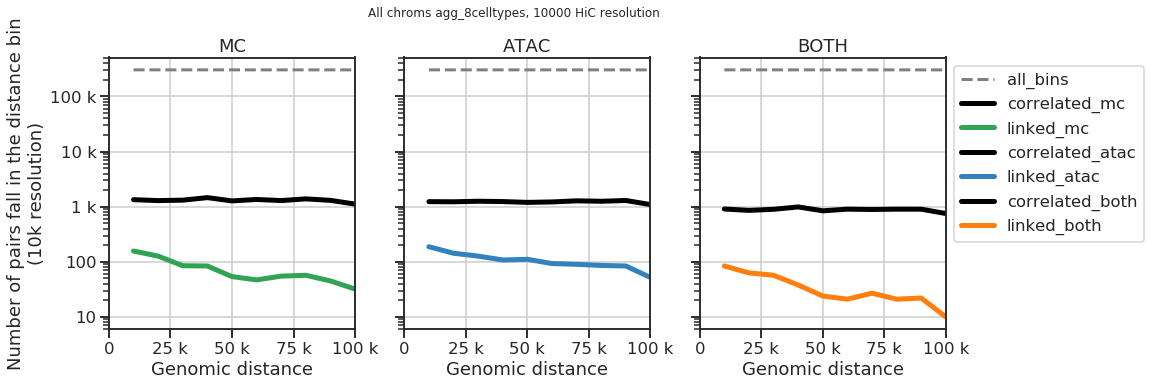

0.9
/cndd2/fangming/sphere_old/enhancers/scripts/results_new/hic_contact_enrichment_metacell_liftover0.90_celltypespec_{}_{}_{}_{}.pkl
/cndd2/fangming/sphere_old/enhancers/scripts/figures/hic_contact_enrichment_metacell_liftover0.90_celltypespec_{}.pdf
/cndd2/fangming/sphere_old/enhancers/scripts/figures/hic_contact_enrichment_metacell_liftover0.90_celltypespec_agg_8celltypes_10000_plot1_v4.pdf.pdf


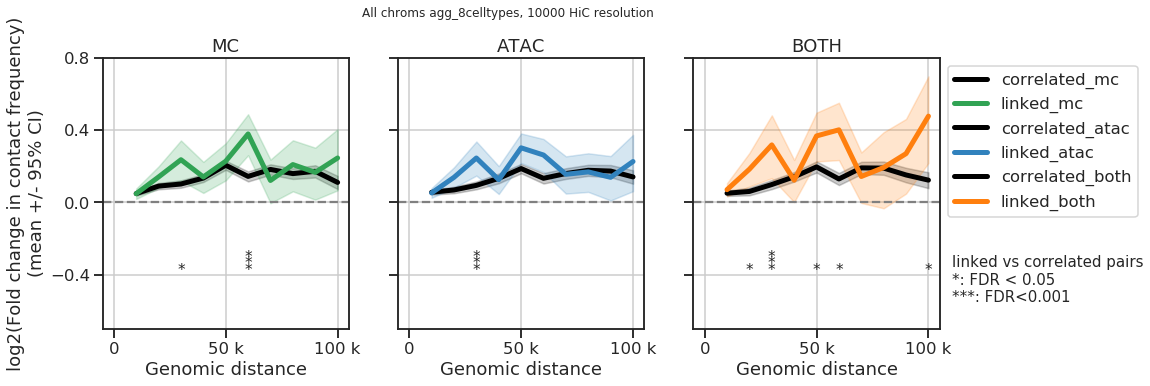

/cndd2/fangming/sphere_old/enhancers/scripts/figures/hic_contact_enrichment_metacell_liftover0.90_celltypespec_agg_8celltypes_10000_plot1_v3_cov_test.pdf.pdf


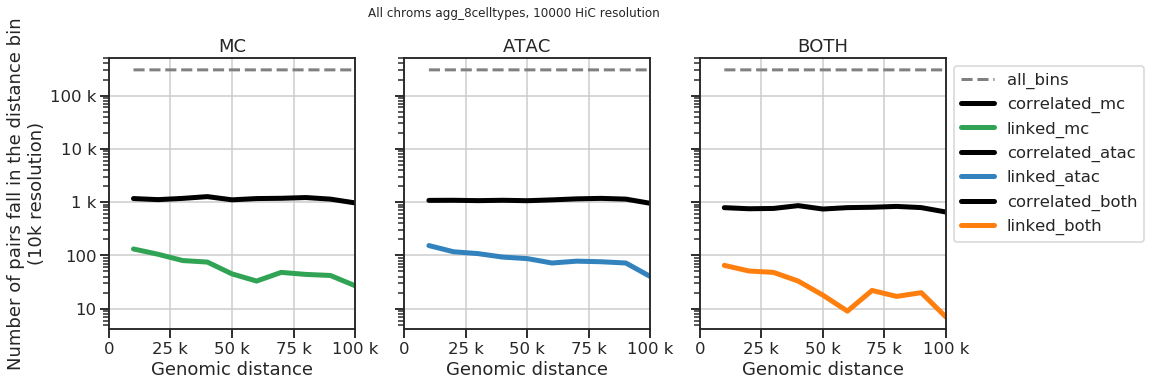

0.95
/cndd2/fangming/sphere_old/enhancers/scripts/results_new/hic_contact_enrichment_metacell_liftover0.95_celltypespec_{}_{}_{}_{}.pkl
/cndd2/fangming/sphere_old/enhancers/scripts/figures/hic_contact_enrichment_metacell_liftover0.95_celltypespec_{}.pdf
/cndd2/fangming/sphere_old/enhancers/scripts/figures/hic_contact_enrichment_metacell_liftover0.95_celltypespec_agg_8celltypes_10000_plot1_v4.pdf.pdf


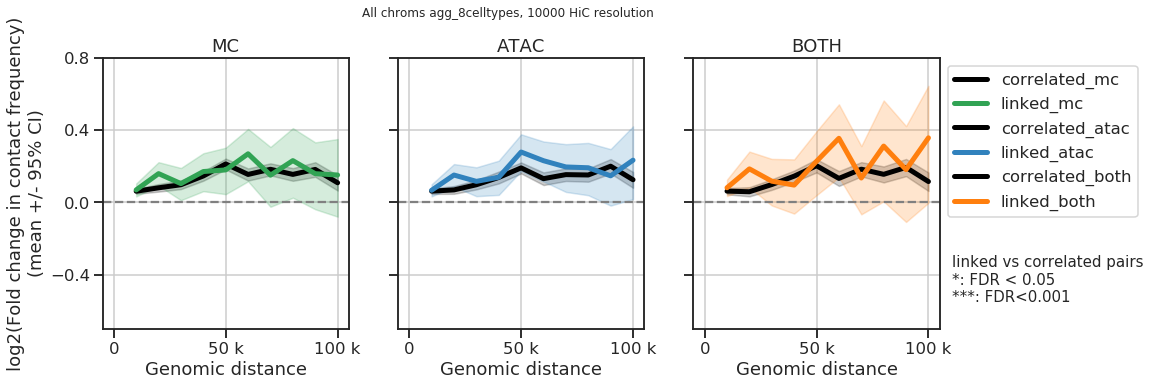

/cndd2/fangming/sphere_old/enhancers/scripts/figures/hic_contact_enrichment_metacell_liftover0.95_celltypespec_agg_8celltypes_10000_plot1_v3_cov_test.pdf.pdf


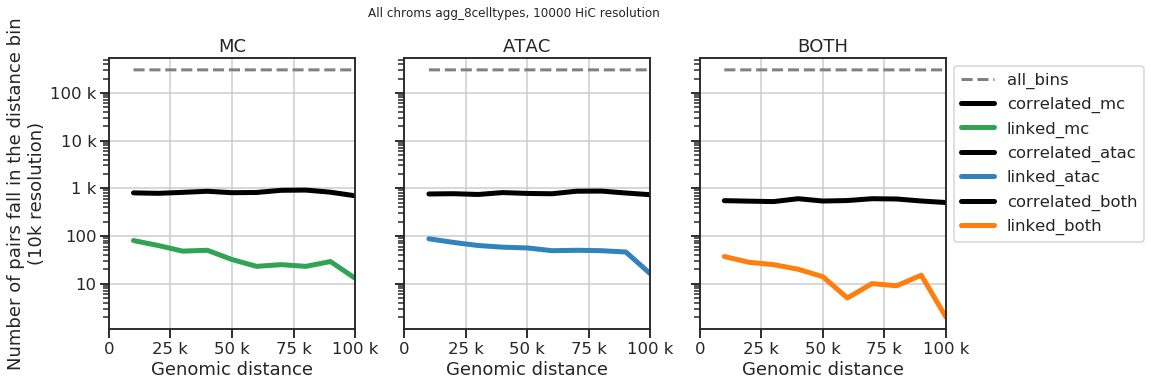

1.0
/cndd2/fangming/sphere_old/enhancers/scripts/results_new/hic_contact_enrichment_metacell_liftover1.00_celltypespec_{}_{}_{}_{}.pkl
/cndd2/fangming/sphere_old/enhancers/scripts/figures/hic_contact_enrichment_metacell_liftover1.00_celltypespec_{}.pdf
/cndd2/fangming/sphere_old/enhancers/scripts/figures/hic_contact_enrichment_metacell_liftover1.00_celltypespec_agg_8celltypes_10000_plot1_v4.pdf.pdf


/cndd2/fangming/venvs/hic_py3p6/lib/python3.6/site-packages/scipy/stats/stats.py:3960: RuntimeWarning: divide by zero encountered in true_divide
  denom = np.sqrt(svar * (1.0 / n1 + 1.0 / n2))
/cndd2/fangming/projects/scf_enhancers/scripts/scf_enhancer_paper/hic/hic_plot_utils.py:405: RuntimeWarning: invalid value encountered in true_divide
  contacts_sig_pairs_std[_name]*1.96/np.sqrt(contacts_sig_pairs_n[_name]),
/cndd2/fangming/projects/scf_enhancers/scripts/scf_enhancer_paper/hic/hic_plot_utils.py:409: RuntimeWarning: invalid value encountered in log2
  ax.fill_between(_x, np.log2((_y-_yerr)/contacts_mean), np.log2((_y+_yerr)/contacts_mean), color=_color, alpha=0.2)
/cndd2/fangming/projects/scf_enhancers/scripts/scf_enhancer_paper/hic/hic_plot_utils.py:410: RuntimeWarning: divide by zero encountered in log2
  ax.plot(_x, np.log2(_y/contacts_mean), _linestyle, color=_color, linewidth=_linewidth, label=_label, alpha=1)


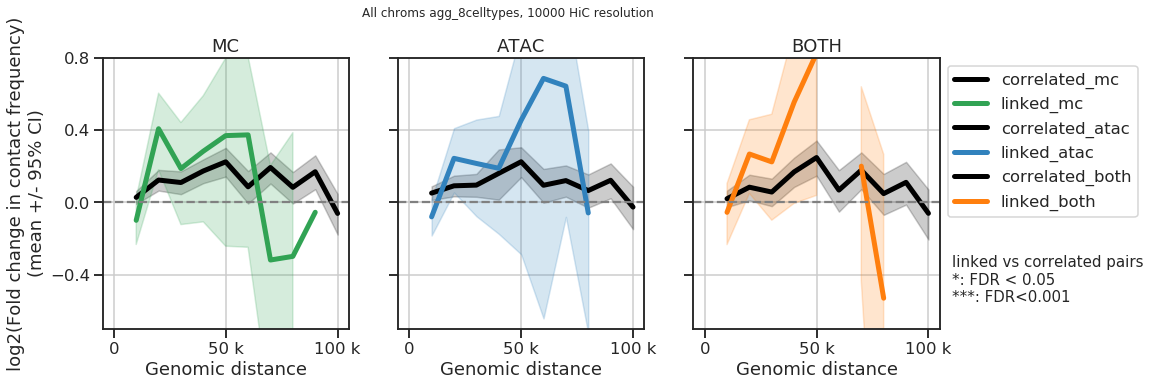

/cndd2/fangming/sphere_old/enhancers/scripts/figures/hic_contact_enrichment_metacell_liftover1.00_celltypespec_agg_8celltypes_10000_plot1_v3_cov_test.pdf.pdf


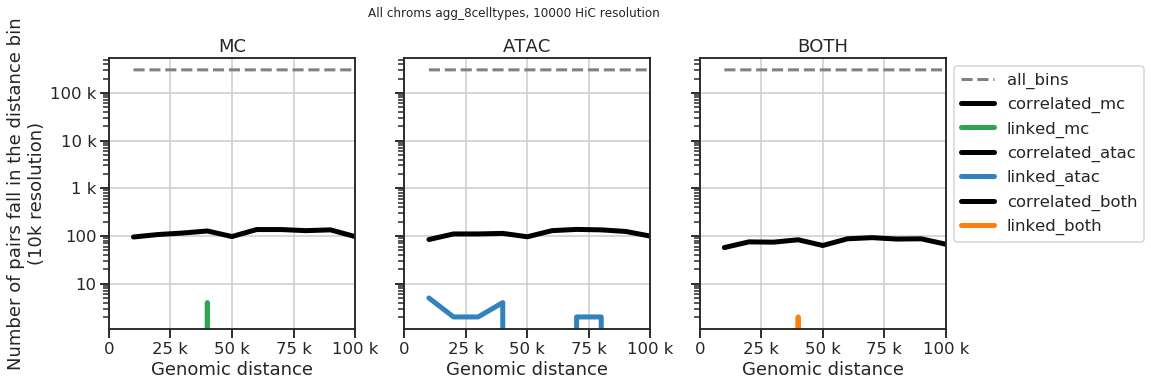

In [16]:
for min_match in min_matches:
    print(min_match)
    
    input_res_format = input_res_metaformat.format(min_match)
    print(input_res_format)

    output_fig_format = output_fig_metaformat.format(min_match)
    print(output_fig_format)

    # combine all cell types

    contacts_mean_all = []
    contacts_std_all = []
    contacts_n_all = []

    contacts_sig_pairs_mean_all = {track: [] for track in track_names}
    contacts_sig_pairs_std_all = {track: [] for track in track_names}
    contacts_sig_pairs_n_all = {track: [] for track in track_names}


    for celltype in celltypes:
        input_res = input_res_format.format(active_th, celltype, resolution, date)

        # get 
        with open(input_res, 'rb') as fh:
            (distances, 
             contacts_mean, contacts_std, contacts_n,
             contacts_sig_pairs_mean, 
             contacts_sig_pairs_std, 
             contacts_sig_pairs_n, 
            ) = pickle.load(fh)

        # contacts: by regions -> celltype by regions -> by regions
        contacts_mean_all.append(contacts_mean)
        contacts_std_all.append(contacts_std)
        contacts_n_all.append(contacts_n)

        # contacts_sig_pairs: key by regions -> key by (celltype by regions) -> key by regions
        for key in contacts_sig_pairs_mean.keys():
            contacts_sig_pairs_mean_all[key].append(contacts_sig_pairs_mean[key])
            contacts_sig_pairs_std_all[key].append(contacts_sig_pairs_std[key])
            contacts_sig_pairs_n_all[key].append(contacts_sig_pairs_n[key])

    # celltype by region 
    contacts_mean_all = np.array(contacts_mean_all)
    contacts_std_all = np.array(contacts_std_all)
    contacts_n_all = np.array(contacts_n_all)
    for key in contacts_sig_pairs_mean_all.keys():
        contacts_sig_pairs_mean_all[key] = np.array(contacts_sig_pairs_mean_all[key])
        contacts_sig_pairs_std_all[key] = np.array(contacts_sig_pairs_std_all[key])
        contacts_sig_pairs_n_all[key] = np.array(contacts_sig_pairs_n_all[key])

    # by region
    (contacts_mean_agg, contacts_std_agg, contacts_n_agg,
    ) = aggregate_mean_std_matrix(contacts_mean_all, contacts_std_all, contacts_n_all)

    # key by region
    contacts_sig_pairs_mean_agg = {track: [] for track in track_names}
    contacts_sig_pairs_std_agg = {track: [] for track in track_names}
    contacts_sig_pairs_n_agg = {track: [] for track in track_names}
    for key in contacts_sig_pairs_mean_all.keys():
        (contacts_sig_pairs_mean_agg[key], 
         contacts_sig_pairs_std_agg[key], 
         contacts_sig_pairs_n_agg[key], 
        ) = aggregate_mean_std_matrix(contacts_sig_pairs_mean_all[key], 
                                      contacts_sig_pairs_std_all[key], 
                                      contacts_sig_pairs_n_all[key], 
                                     )

    p_th1 = 0.05
    p_th2 = 0.001
    (mean_fcs_bck, padjs_bck, 
     mean_fcs_correlated, padjs_correlated,) = ttest_routine(contacts_mean_agg, 
                                                             contacts_std_agg, 
                                                             contacts_n_agg, 
                                                             contacts_sig_pairs_mean_agg,
                                                             contacts_sig_pairs_std_agg,
                                                             contacts_sig_pairs_n_agg,
                                                             p_th1=p_th1, p_th2=p_th2)
    
    # plot
    celltype = 'agg_8celltypes'

    output_fig = output_fig_format.format('{}_{}_plot1_v4.pdf'.format(celltype, resolution))
    print(output_fig)
    plot1_v4(distances, celltype, resolution, 
             track_names, track_palette,
             contacts_mean_agg, contacts_std_agg, contacts_n_agg, 
             contacts_sig_pairs_mean_agg, contacts_sig_pairs_std_agg, contacts_sig_pairs_n_agg,
             padjs_correlated,
             output_fig,
             ylim=[-0.7, 0.8],
             yticks=[-0.4, 0, 0.4, 0.8],
             )

    output_fig = output_fig_format.format('{}_{}_plot1_v3_cov_test.pdf'.format(celltype, resolution))
    print(output_fig)
    plot1_v3_cov(distances, celltype, resolution, 
             track_names, track_palette, 
             contacts_mean, contacts_std, contacts_n, 
             contacts_sig_pairs_mean, contacts_sig_pairs_std, contacts_sig_pairs_n,
             output_fig,
             )